# Part I Objective

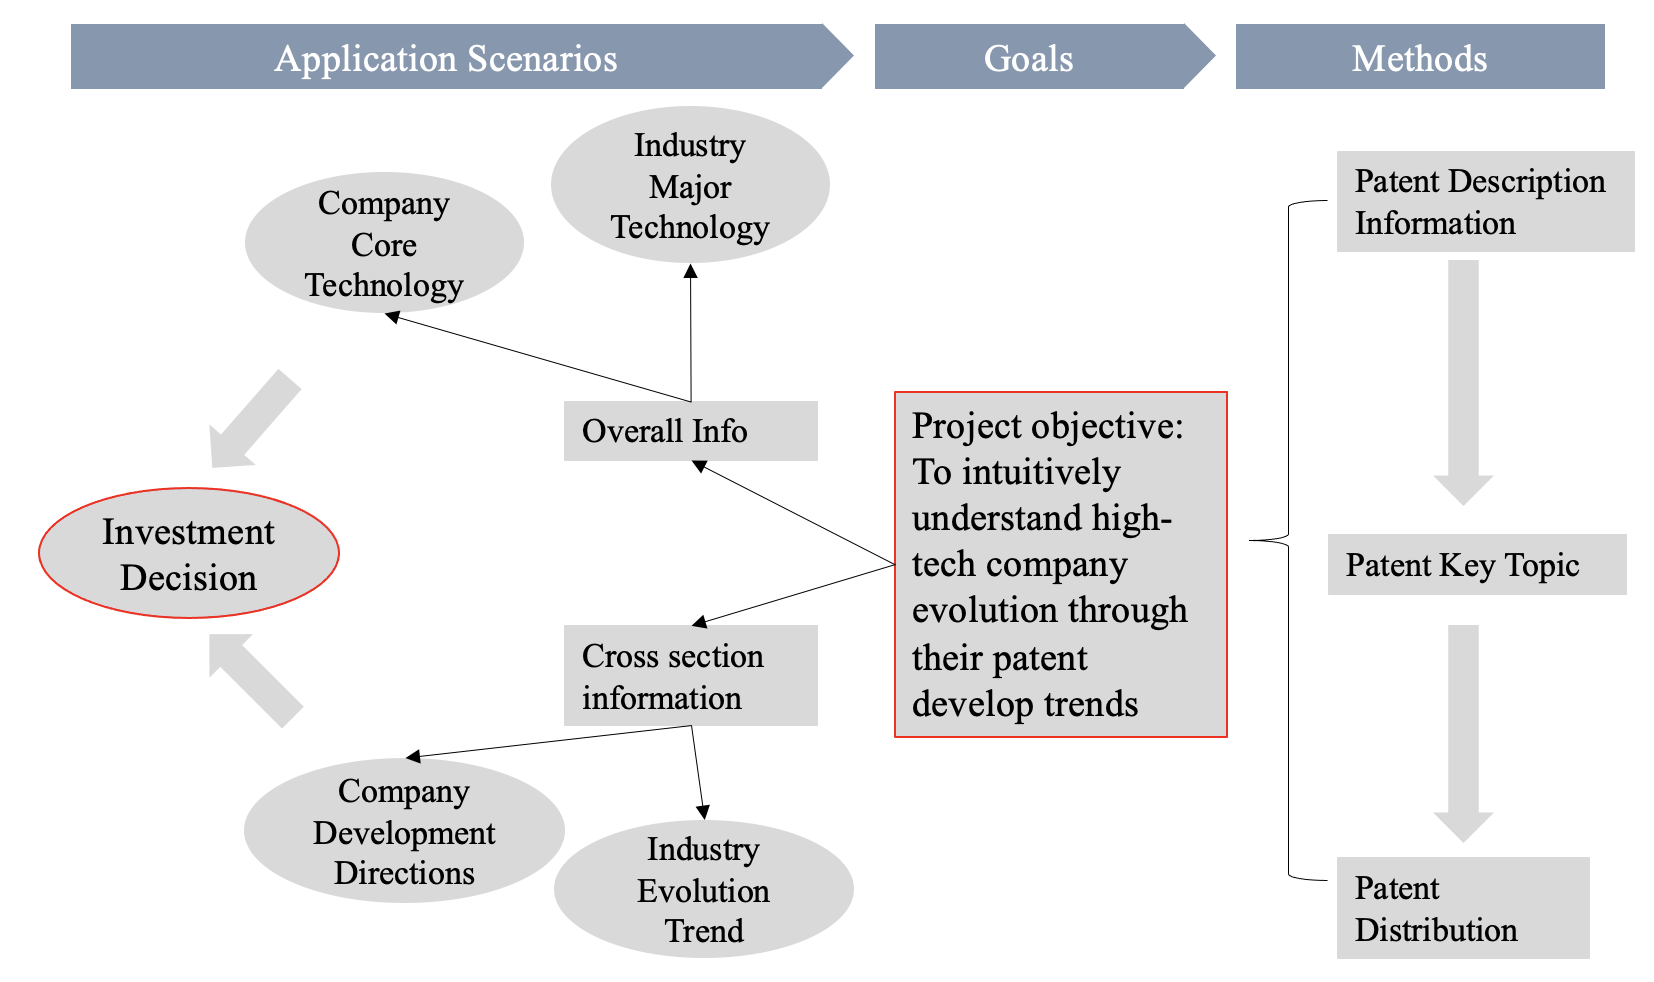
We want to find keywords that could embed the patents into a vertical high-dimensional space from the patent text data. Patents do not have their own keywords and the classification number is relatively general, so we want to extract keywords from the text by using word vector

We use Bert and MPNet's pre-training model and github's open source keyBert package fetching pre-training model

# Part II DataSet
# 2.1 Data Source
## Patent Retriving Based on Google Big Query
Google BigQuery is Google's Cloud data warehousing solution that is part of the Google Cloud Platform. It is designed to deal with "big data" reporting, analytics and data science.

Using SQL queries, we can use BigQuery to do more in-depth statistical analysis, predictive analysis, and more than you can do in the Google Analytics interface

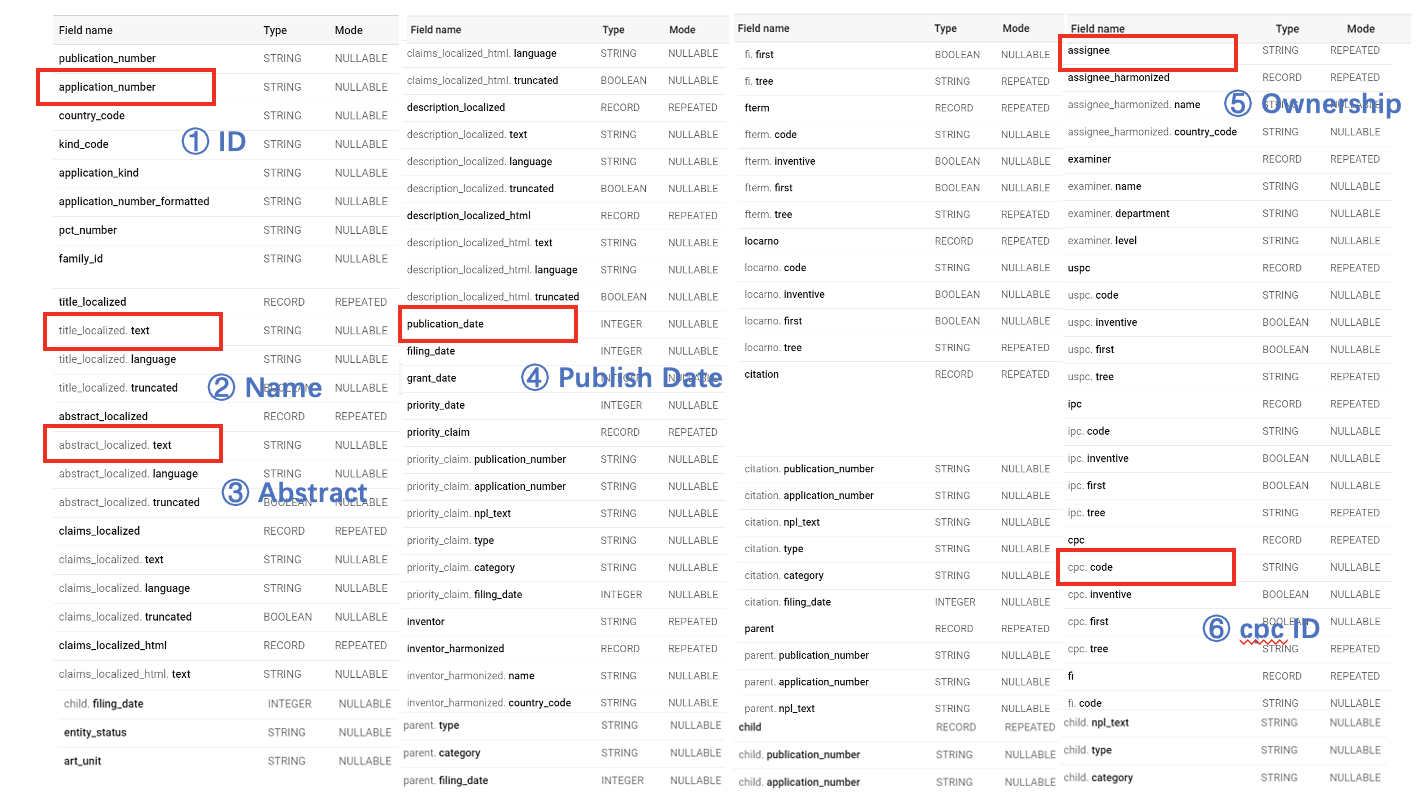


# 2.2 Data Cleaning

In [1]:
import pandas as pd
import os
import pickle

p_data = "./data"
f_patent_all_p = "{}/patents/google_patents.pickle".format(p_data)
f_patent_clean_p = "{}/patents/google_patents_clean.pickle".format(p_data)
f_thesis_p = "{}/thesis/science_direct.pickle".format(p_data)


In [2]:
# Case 1: Data has been washed. The following method is the switch to read data and, if so, to read preprocessed data from the path
LOAD = True
# 情况2： If no data is read, we do the following preprocessing steps and save the processed data
# Patent data contains multiple CSVS. We integrate them into one CSV and pickle for quick data reading

AGG_CSV = False
# Clean up the company's US patent data
CLEAN_PICKLE = False
# Clean up the paper data used in the test, which will be used to verify the accuracy of the model later
CLEAN_THESIS_ABS = False

if not LOAD:
    if AGG_CSV:
        f_patents = os.listdir(p_data)
        f_patent_all = "{}/patents/google_patents.csv".format(p_data)
        f_patent_all_p = "{}/patents/google_patents.pickle".format(p_data)

        s_patent_all = ""
        for f_patent in f_patents:
            f_patent = "{}/{}".format(p_data, f_patent)
            with open(f_patent, "r", encoding="utf-8") as f:
                s_patent = f.read().strip("\n")
                s_patent_all += "\n" + s_patent

        with open(f_patent_all, "w", encoding="utf-8") as f:
            f.write(s_patent_all)

        patent_df = pd.read_csv(f_patent_all)

        with open(f_patent_all_p, "wb") as f:
            pickle.dump(patent_df)

    if CLEAN_PICKLE:
        with open(f_patent_all_p, "rb") as f:
            patent_df = pickle.load(f)

        def patent_filter(line):
            i = {
                "title": 0,
                "publication_date": 1,
                "application_number": 2,
                "assignees": 3,
                "cpc": 4,
                "abstract": 5,
            }
            flag = line[i["application_number"]][:2] == "US"
            return flag

        patent_clean_df = patent_df[patent_df.apply(patent_filter, axis=1)]

        def cpc_agg(df):
            s = "; ".join(df["cpc"])
            df = df.iloc[0, :]
            df["cpc"] = s
            return df

        patent_clean_df = patent_clean_df.groupby("application_number").apply(cpc_agg)
        patent_clean_df = patent_clean_df.reset_index(drop=True)

        def assignees_clean(s):
            s2 = (
                s.replace(",Inc", ", Inc")
                .replace(", Inc", " Inc")
                .replace(",Llc", ", Llc")
                .replace(", Llc", " Llc")
                .replace(", a", "| a")
                .replace(", A", "| a")
                .replace(",", ";")
                .replace("|", ",")
                .replace("  ", " ")
                .replace(" ,", ",")
                .replace("Delware", "Delaware")
            )
            return s2

        t = patent_clean_df["assignees"]
        patent_clean_df["assignees"] = t[t.apply(lambda x: ", " in x)]

        patent_clean_df["publication_date"] = pd.to_datetime(
            patent_clean_df["publication_date"], format="%Y%m%d"
        )

        with open(f_patent_clean_p, "wb") as f:
            pickle.dump(patent_clean_df, f)

    if CLEAN_THESIS_ABS:
        f_thesis = "{}/thesis/science_direct.xlsx".format(p_data)
        df_thesis = pd.read_excel(f_thesis)

        df_thesis = df_thesis.iloc[:, 1:]
        df_thesis["KW"] = (
            df_thesis["KW"].apply(lambda x: x.replace(";", "; ")).reset_index(drop=True)
        )

        with open(f_thesis_p, "wb") as f:
            pickle.dump(df_thesis, f)

else:
    with open(f_patent_clean_p, "rb") as f:
        df_patent = pickle.load(f)
    with open(f_thesis_p, "rb") as f:
        df_thesis = pickle.load(f)


In [6]:
# Data Structure
df_patent.head(5)

,title,publication_date,application_number,assignees,cpc,abstract
0,Procede et systeme pour presenter des annonces...,2004-07-01,US-0321952-W,NaN,G06Q30/0257; G06Q30/0275; G06Q30/0257; G06Q30/...,Methods and systems for providing advertising ...
1,Procede et systeme de fourniture de publicites...,2004-02-05,US-0323010-W,NaN,G06Q30/0251; G06Q30/0251; G06Q30/0251; G06Q30/...,Methods and Systems that allow an Internet dis...
2,Procede et systeme destines a fournir des list...,2005-01-06,US-0326494-W,NaN,G06Q30/0242; G06Q30/0275; G06Q30/0242; G06Q30/...,An internet advertisement listings provider (1...
3,Methods and apparatus for serving relevant adv...,2004-05-27,US-0330232-W,NaN,G06Q30/0251; G06Q30/0251; G06Q30/02; G06Q30/02...,The relevance of advertisements to a user&#39;...
4,Presentation d&#39;annonces basee sur le contenu,2004-05-27,US-0330233-W,NaN,G06F16/951; Y10S707/99948; Y10S707/99945; Y10S...,Advertisers (110) are permitted to put targete...


In [8]:
# Patent Time Range
[df_patent["publication_date"].min(), df_patent["publication_date"].max()]

[Timestamp('2002-04-11 00:00:00'), Timestamp('2021-05-06 00:00:00')]

In [9]:
# Number of Patents
df_patent["publication_date"].count()

36104

# Part III Key Words
Key principles: approximation and additivity of word vector

This paper introduces the idea of sentence average word vector approximation to sentence word vector, so as to find n words with maximum cosine similarity to sentence word vector as keywords, and take their cosine similarity as their importance degree
Next, the abstracted text of patent data is used as the material to extract keywords

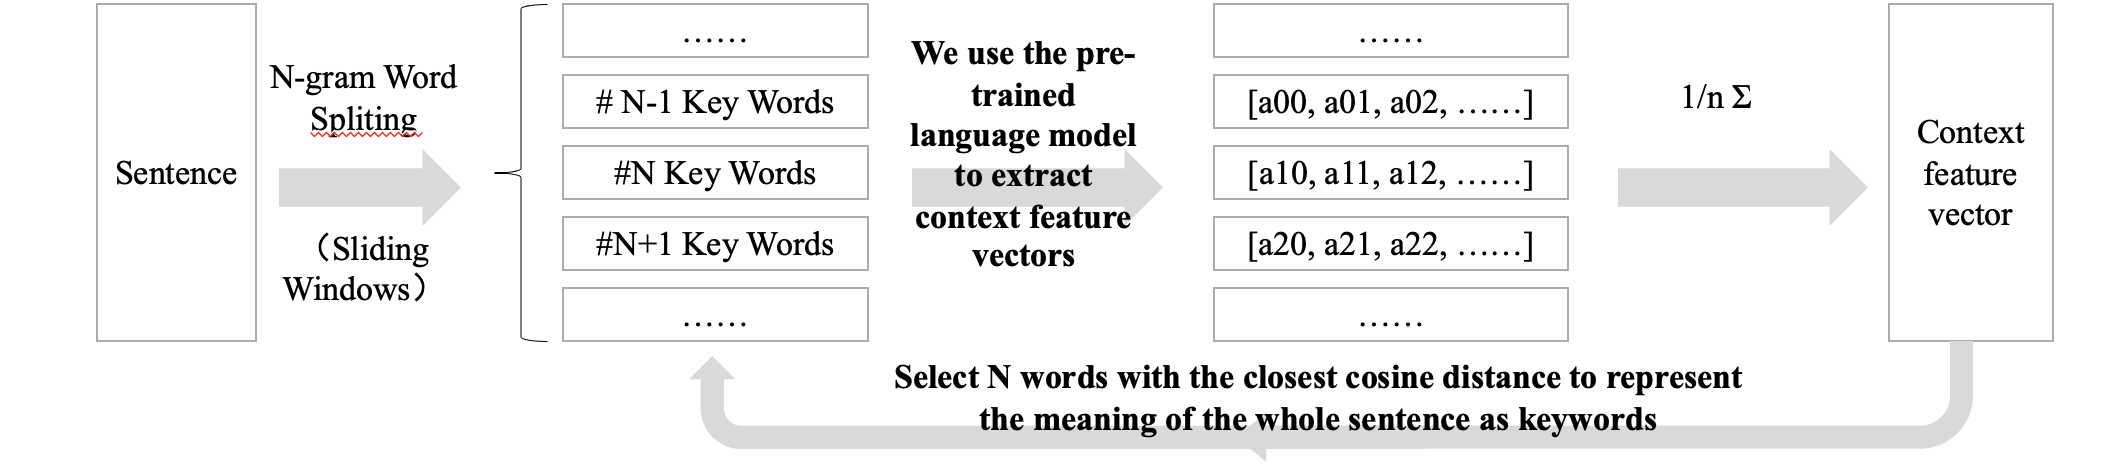

In [11]:
from my_utils import get_keybert_model, drop_dup_kws
from load_data import df_patent
from tqdm import tqdm
import pickle


p_data = "./data"
f_patent_keybert_p = "{}/patents/keywords_keyBert_mpnet.pickle".format(p_data)


In [12]:
# Due to the time limitation, we just put our results here.
# Case 1: The key words and their importance have been calculated and could be read directly.
LOAD = True
# Case 2: If no data is read, we set the following variables for keyword and word vector extraction.
# We pass the patent text one by one or pass all the patent text matrix at a time
# The latter step takes up too much memory

ONE_BY_ONE = True
# Keyword length range, default is 1-2 word words
keyphrase_length = (1, 2)
# The top 30 keywords are selected for each patent text
top_n = 30
# Using the MMR method, the configuration of the package
mmr = True
maxsum = not mmr

if not LOAD:
    def get_no_dup_kws(s, keybert_model):
        global keyphrase_length, mmr, maxsum, top_n

        keywords = keybert_model._extract_keywords_single_doc(
            s,
            top_n=top_n,
            keyphrase_ngram_range=keyphrase_length,
            use_mmr=mmr,
            use_maxsum=maxsum,
            diversity=0.5,
            stop_words=None,
        )
        no_dup_keywords = drop_dup_kws(keywords, keybert_model.model, thd=0.6)
        return no_dup_keywords


    def get_no_dup_kws_from_list(l_s, keybert_model):
        global keyphrase_length, top_n

        keywords = keybert_model._extract_keywords_multiple_docs(
            l_s, top_n=top_n, keyphrase_ngram_range=keyphrase_length, stop_words=None
        )
        no_dup_keywords = [
            drop_dup_kws(i, keybert_model.model, thd=0.6) for i in tqdm(keywords)
        ]
        return no_dup_keywords


    model = get_keybert_model()

    if ONE_BY_ONE:
        l_patent_kws = []
        for idx in tqdm(df_patent.index):
            s_ab = df_patent.loc[idx, "abstract"]
            l_kws_test = get_no_dup_kws(s_ab, model)
            l_patent_kws.append(l_kws_test)
    else:
        l_ab = df_patent.loc[:, "abstract"]
        l_patent_kws = get_no_dup_kws_from_list(l_ab, model)

    df_patent_keybert = df_patent.iloc[: len(l_patent_kws), :]
    df_patent_keybert["KWG"] = l_patent_kws

    with open(f_patent_keybert_p, "wb") as f:
        pickle.dump(df_patent_keybert, f)
else:
    with open(f_patent_keybert_p, "rb") as f:
        df_patent_keybert = pickle.load(f)

In [15]:
# The data structure is the original patent data with a column of extracted keywords and  importance at the end
df_patent_keybert.head(5)

,title,publication_date,application_number,assignees,cpc,abstract,KWG
0,Procede et systeme pour presenter des annonces...,2004-07-01,US-0321952-W,NaN,G06Q30/0257; G06Q30/0275; G06Q30/0257; G06Q30/...,Methods and systems for providing advertising ...,"[(advertising content, 0.5909), (independent d..."
1,Procede et systeme de fourniture de publicites...,2004-02-05,US-0323010-W,NaN,G06Q30/0251; G06Q30/0251; G06Q30/0251; G06Q30/...,Methods and Systems that allow an Internet dis...,"[(internet distribution, 0.5312), (advertising..."
2,Procede et systeme destines a fournir des list...,2005-01-06,US-0326494-W,NaN,G06Q30/0242; G06Q30/0275; G06Q30/0242; G06Q30/...,An internet advertisement listings provider (1...,"[(advertisers 12a, 0.6414), (listings provider..."
3,Methods and apparatus for serving relevant adv...,2004-05-27,US-0330232-W,NaN,G06Q30/0251; G06Q30/0251; G06Q30/02; G06Q30/02...,The relevance of advertisements to a user&#39;...,"[(relevant advertisements, 0.65), (topics one,..."
4,Presentation d&#39;annonces basee sur le contenu,2004-05-27,US-0330233-W,NaN,G06F16/951; Y10S707/99948; Y10S707/99945; Y10S...,Advertisers (110) are permitted to put targete...,"[(targeted ads, 0.6729), (be relevant, 0.3292)..."


In [16]:
# Keywords are arranged in descending order of importance
df_patent_keybert.iloc[0, -1]

[('advertising content', 0.5909),
 ('independent delivery', 0.548),
 ('directed', 0.2566),
 ('narrowly targeted', 0.2469),
 ('levels', 0.1946)]

# Part IV Accuracy Verification
Since papers and patent briefs have similar language styles and come with keywords, we can think of it as keyword tagged data.

We use the cleaned paper data as the material.

The average accuracy of extracted keywords was compared with YAKE, a rule-based rather than machine learning model with known good results

In [1]:
# The following code will compare the paper data with the two models and write the HTML.
# The result can be observed in p_html path after running

from my_utils import get_keybert_model, drop_dup_kws, write_result_to_html, sort_kws
from load_data import df_thesis
from tqdm import tqdm
import pickle
from yake import yake
from yake.highlight import TextHighlighter
import time


p_data = "./data"
f_thesis_keybert_p = "{}/thesis/keywords_keyBert_mpnet.pickle".format(p_data)
f_thesis_yake_p = "{}/thesis/keywords_yake3.pickle".format(p_data)

p_html = "./labeled_text"


TEST_BERT_YAKE = [False, False]

max_ngram_size = 3

# BERT settings
ONE_BY_ONE = True
top_n = 20 * max_ngram_size - 10
keyphrase_length = (1, max_ngram_size)
mmr = True
maxsum = not mmr

# YAKE settings


def get_no_dup_kws(s, keybert_model):
    global keyphrase_length, mmr, maxsum, top_n

    keywords = keybert_model._extract_keywords_single_doc(
        s,
        top_n=top_n,
        keyphrase_ngram_range=keyphrase_length,
        use_mmr=mmr,
        use_maxsum=maxsum,
        diversity=0.5,
        stop_words=None,
    )
    no_dup_keywords = drop_dup_kws(keywords, keybert_model.model, thd=0.6)
    return no_dup_keywords


def get_no_dup_kws_from_list(l_s, keybert_model):
    global keyphrase_length, top_n

    keywords = keybert_model._extract_keywords_multiple_docs(
        l_s, top_n=top_n, keyphrase_ngram_range=keyphrase_length, stop_words=None
    )
    no_dup_keywords = [
        drop_dup_kws(i, keybert_model.model, thd=0.6) for i in tqdm(keywords)
    ]
    return no_dup_keywords


if TEST_BERT_YAKE[0]:
    model = get_keybert_model()

    if ONE_BY_ONE:
        l_thesis_kws = []
        for idx in tqdm(range(df_thesis.shape[0])):
            s_url, s_kws_truth, s_ab = df_thesis.iloc[idx, :]
            l_kws_truth = s_kws_truth.split("; ")

            l_kws_test = get_no_dup_kws(s_ab, model)

            n_kws_test = len(l_kws_test)
            n_kws_truth = len(l_kws_truth)
            if n_kws_test < n_kws_truth:
                print("!test word counts: {} < {}".format(n_kws_test, n_kws_truth))
            else:
                l_kws_test = l_kws_test[:n_kws_truth]
            l_thesis_kws.append(l_kws_test)
    else:
        l_ab = df_thesis.loc[:, "abstract"]
        l_thesis_kws = get_no_dup_kws_from_list(l_ab, model)
        for idx in tqdm(range(df_thesis.shape[0])):
            s_url, s_kws_truth, s_ab = df_thesis.iloc[idx, :]
            l_kws_truth = s_kws_truth.split("; ")
            l_kws_test = l_thesis_kws[idx]
            n_kws_test = len(l_kws_test)
            n_kws_truth = len(l_kws_truth)
            if n_kws_test < n_kws_truth:
                print("!test word counts: {} < {}".format(n_kws_test, n_kws_truth))
            else:
                l_kws_test = l_kws_test[:n_kws_truth]
            l_thesis_kws[idx] = l_kws_test

    df_thesis_keybert = df_thesis.iloc[: len(l_thesis_kws), :]
    df_thesis_keybert["KWG"] = l_thesis_kws

    df_thesis_keybert["KW"] = df_thesis_keybert["KW"].apply(lambda x: x.split("; "))

    with open(f_thesis_keybert_p, "wb") as f:
        pickle.dump(df_thesis_keybert, f)


if TEST_BERT_YAKE[1]:
    pyake = yake.KeywordExtractor(lan="en", n=3)

    l_thesis_kws = []
    for idx in tqdm(range(df_thesis.shape[0])):
        s_url, s_kws_truth, s_ab = df_thesis.iloc[idx, :]
        l_kws_truth = s_kws_truth.split("; ")

        l_kws_test = pyake.extract_keywords(s_ab)
        l_kws_test = sort_kws(l_kws_test)

        n_kws_test = len(l_kws_test)
        n_kws_truth = len(l_kws_truth)
        if n_kws_test < n_kws_truth:
            print("!test word counts: {} < {}".format(n_kws_test, n_kws_truth))
        else:
            l_kws_test = l_kws_test[:n_kws_truth]
        l_thesis_kws.append(l_kws_test)

    df_thesis_yake = df_thesis.iloc[: len(l_thesis_kws), :]
    df_thesis_yake["KWG"] = l_thesis_kws

    df_thesis_yake["KW"] = df_thesis_yake["KW"].apply(lambda x: x.split("; "))

    with open(f_thesis_yake_p, "wb") as f:
        pickle.dump(df_thesis_yake, f)


if not TEST_BERT_YAKE[0] and not TEST_BERT_YAKE[1]:
    # s_ab = """
    #     Supervised learning is the machine learning task of learning a function that
    #     maps an input to an output based on example input-output pairs.[1] It infers a
    #     function from labeled training data consisting of a set of training examples.[2]
    #     In supervised learning, each example is a pair consisting of an input object
    #     (typically a vector) and a desired output value (also called the supervisory signal).
    #     A supervised learning algorithm analyzes the training data and produces an inferred function,
    #     which can be used for mapping new examples. An optimal scenario will allow for the
    #     algorithm to correctly determine the class labels for unseen instances. This requires
    #     the learning algorithm to generalize from the training data to unseen situations in a
    #     'reasonable' way (see inductive bias).
    # """

    for idx in tqdm(range(df_thesis.shape[0])):
        s_url, s_kws_truth, s_ab = df_thesis.iloc[idx, :]

        pyake = yake.KeywordExtractor(lan="en", n=3)
        pyake_result = pyake.extract_keywords(s_ab)
        pyake_result = sort_kws(pyake_result)

        model = get_keybert_model()
        model_result = get_no_dup_kws(s_ab, model)

        max_kw_count = min(len(model_result), len(pyake_result))
        model_result = model_result[:max_kw_count]
        pyake_result = pyake_result[:max_kw_count]

        write_result_to_html(
            p_html, s_ab, [pyake_result, model_result], ["YAKE", "BERT"], max_ngram_size
        )


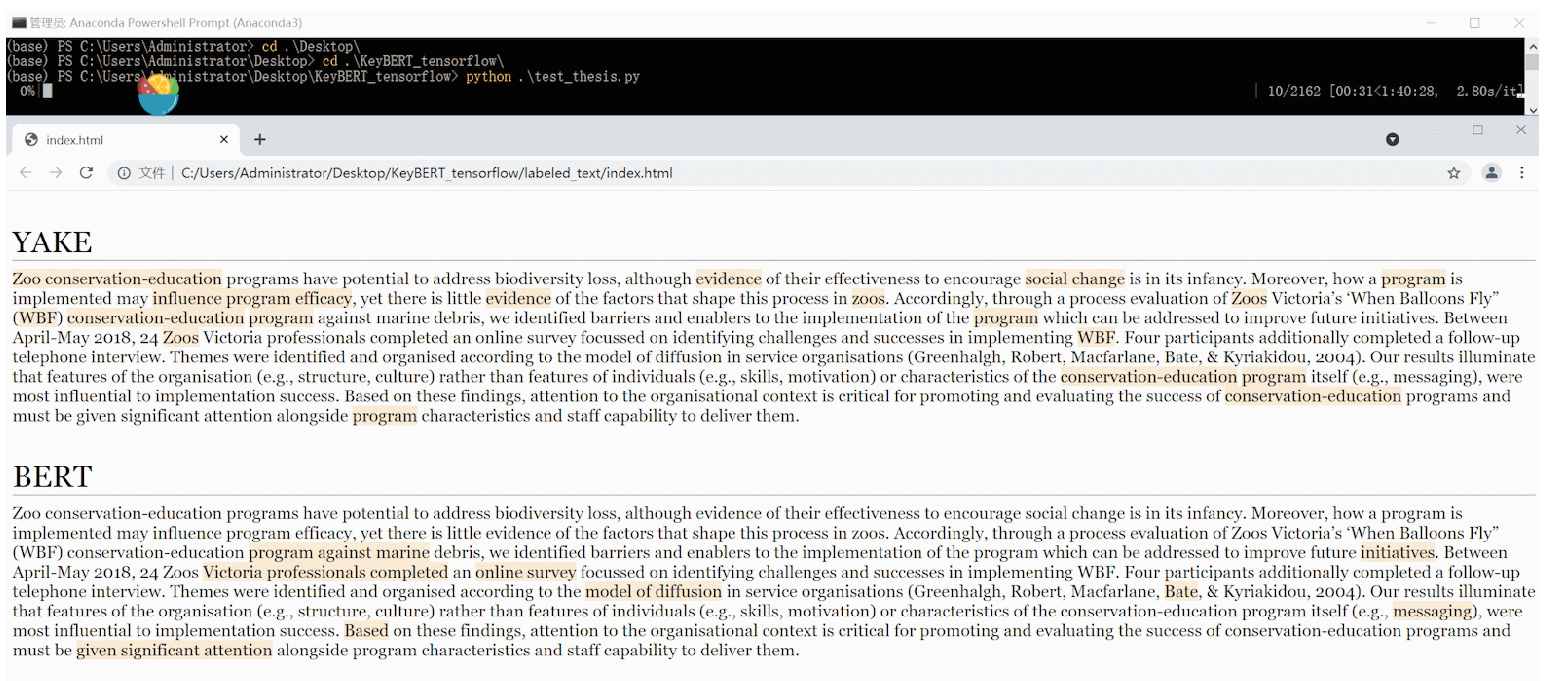

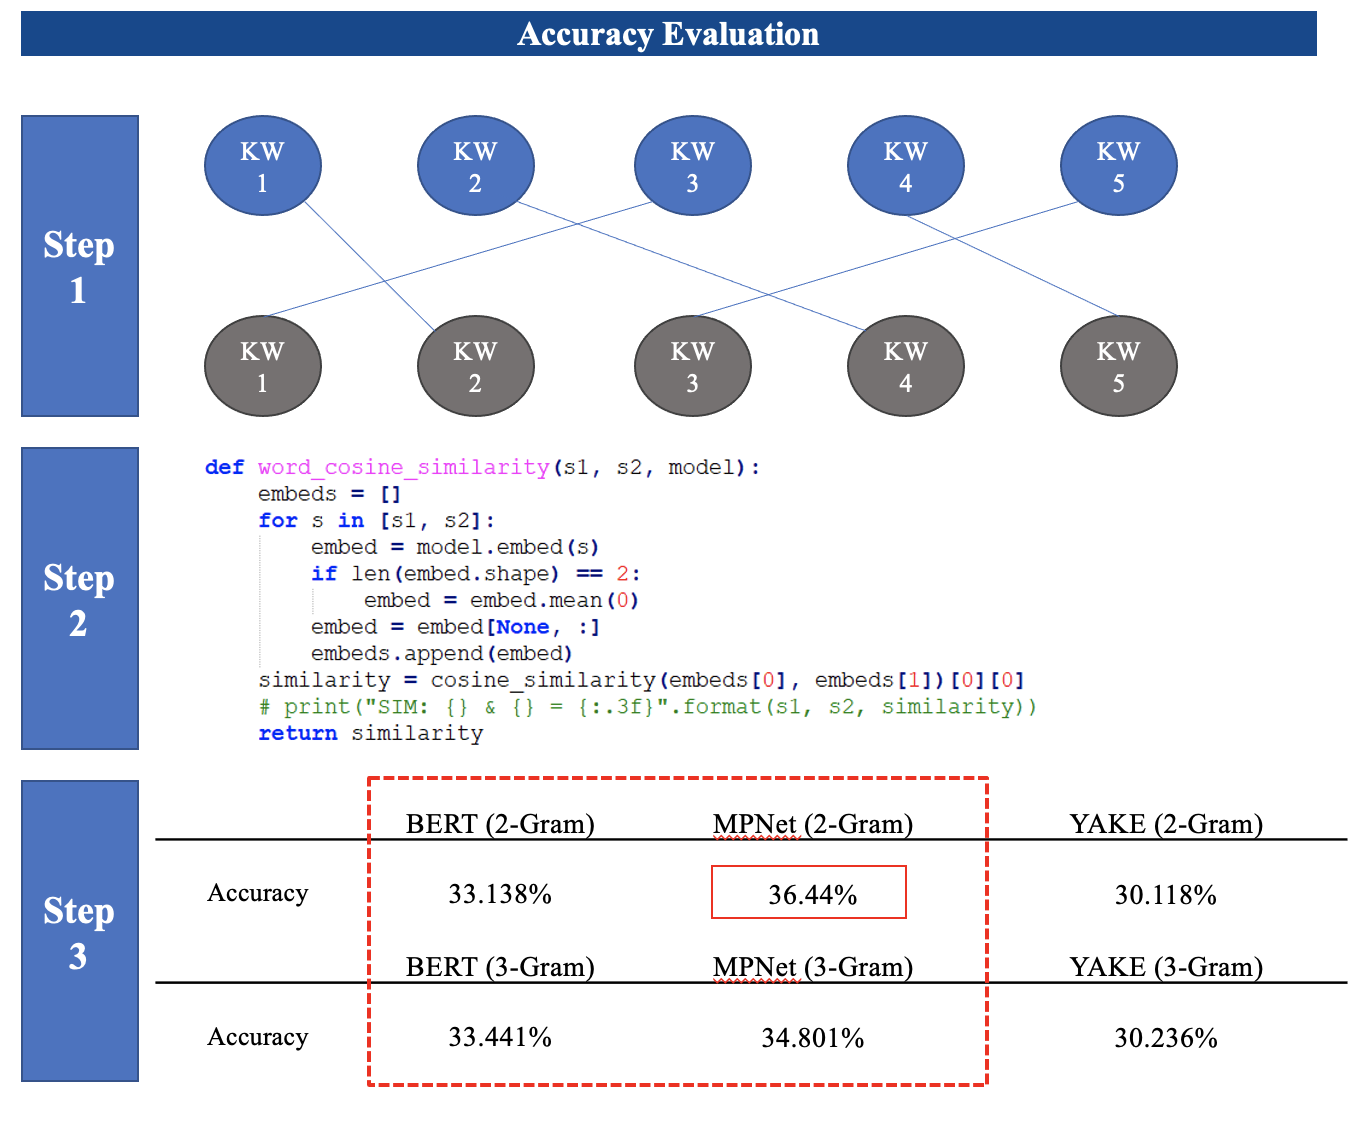

Accuracy test results: the 2-gram MPNet model performed best
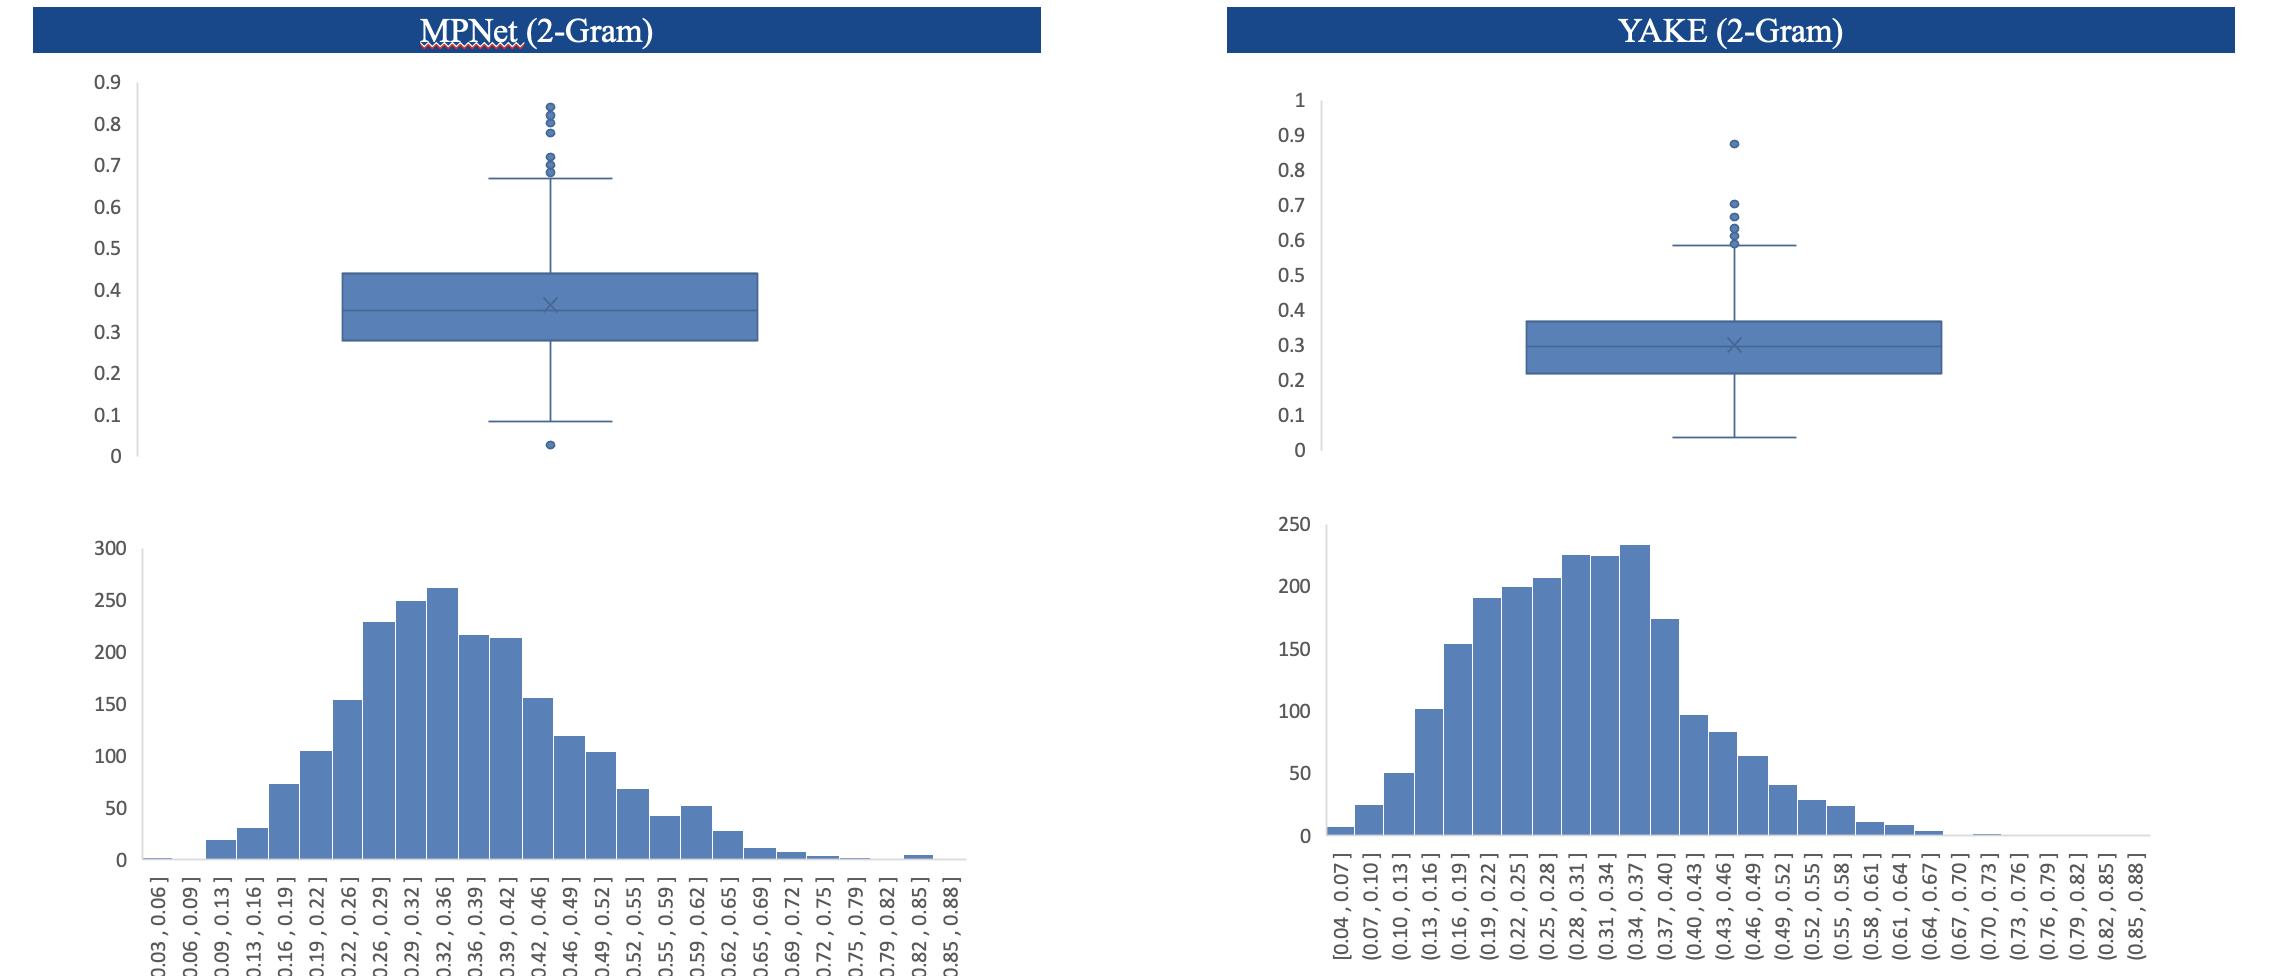

# Part V Visualizaiton
The purpose is to visually understand the distribution of patents through two-dimensional graphics


1. Reduce the patent word vector to 2 dimensions using PCA, merge the keywords of different patent abstracts according to the same word name, and add their importance as the importance of modified keywords in the company's overall patent group
2. Cluster keywords in two-dimensional coordinates, and manually tune the specific number of clusters
3. Visualize the four-dimensional data (X coordinate, Y coordinate, name, importance and classification) of each keyword

Output figure：.\data\plot 

Z:\Temp/ipykernel_27428/4204997014.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: re.sub(re_rm_sub, "", x))
Z:\Temp/ipykernel_27428/4204997014.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: re.sub(re_rm_sub2, "", x))
Z:\Temp/ipykernel_27428/4204997014.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Centers: [[ 0.25242114  0.5426015 ]
 [-0.66234154 -0.5476673 ]
 [ 1.0347917  -0.03023733]
 [ 0.23004864 -0.6585669 ]
 [-0.5217955   0.41794884]]


D:\OneDrive\Documents\code\python\Leasons\Class_MLF\my_utils.py:292: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 20481/20481 [00:12<00:00, 1611.80it/s]
D:\OneDrive\Documents\code\python\Leasons\Class_MLF\my_utils.py:292: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 1250/1250 [00:00<00:00, 1624.27it/s]
D:\OneDrive\Documents\code\python\Leasons\Class_MLF\my_utils.py:292: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 8021/8021 [00:04<00:00, 1608.06it/s]
D:\OneDrive\Documents\code\python\Leasons\Class_MLF\my_utils.py:292: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a n

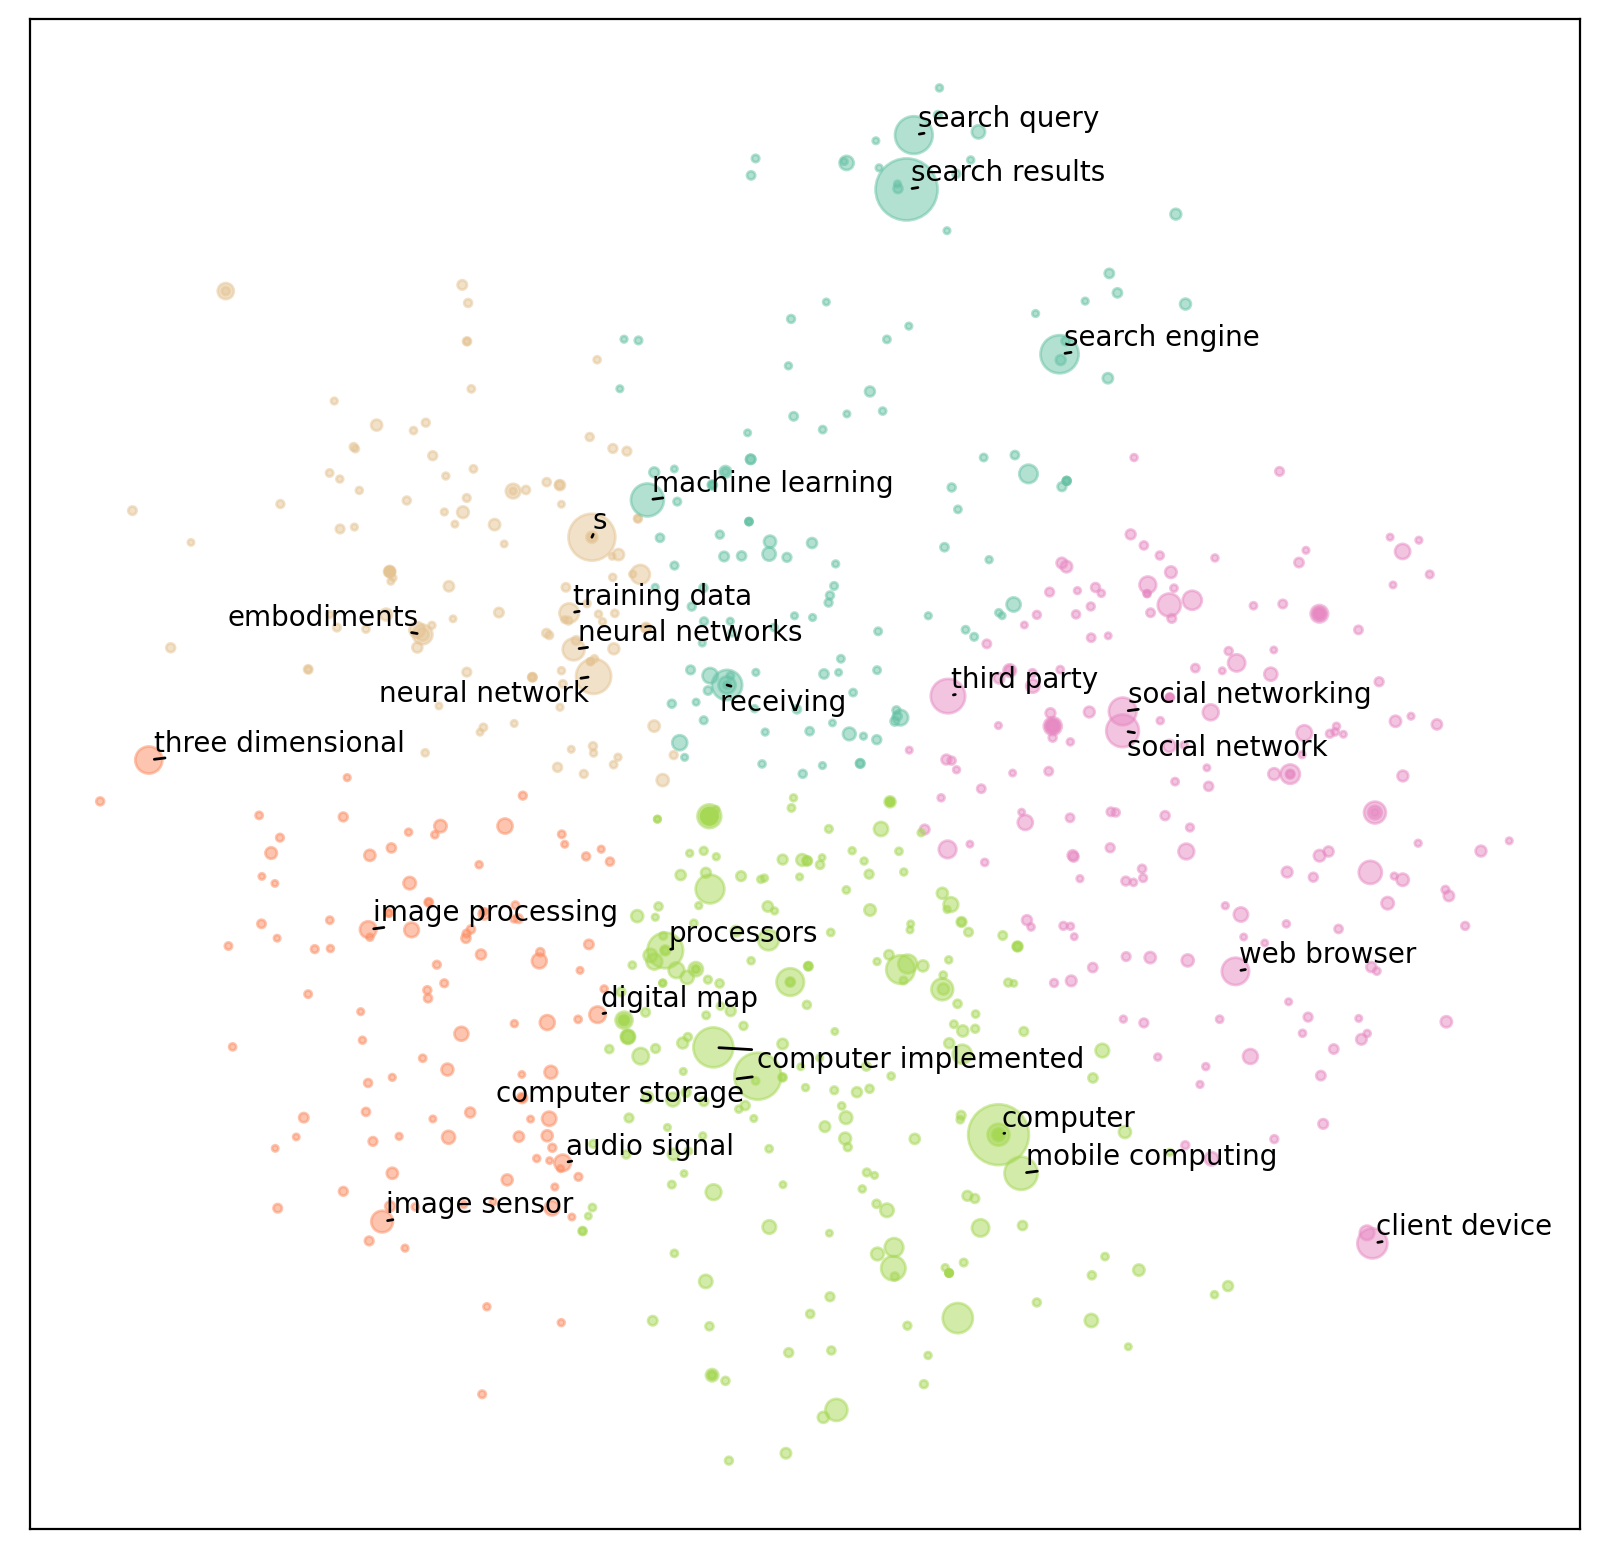

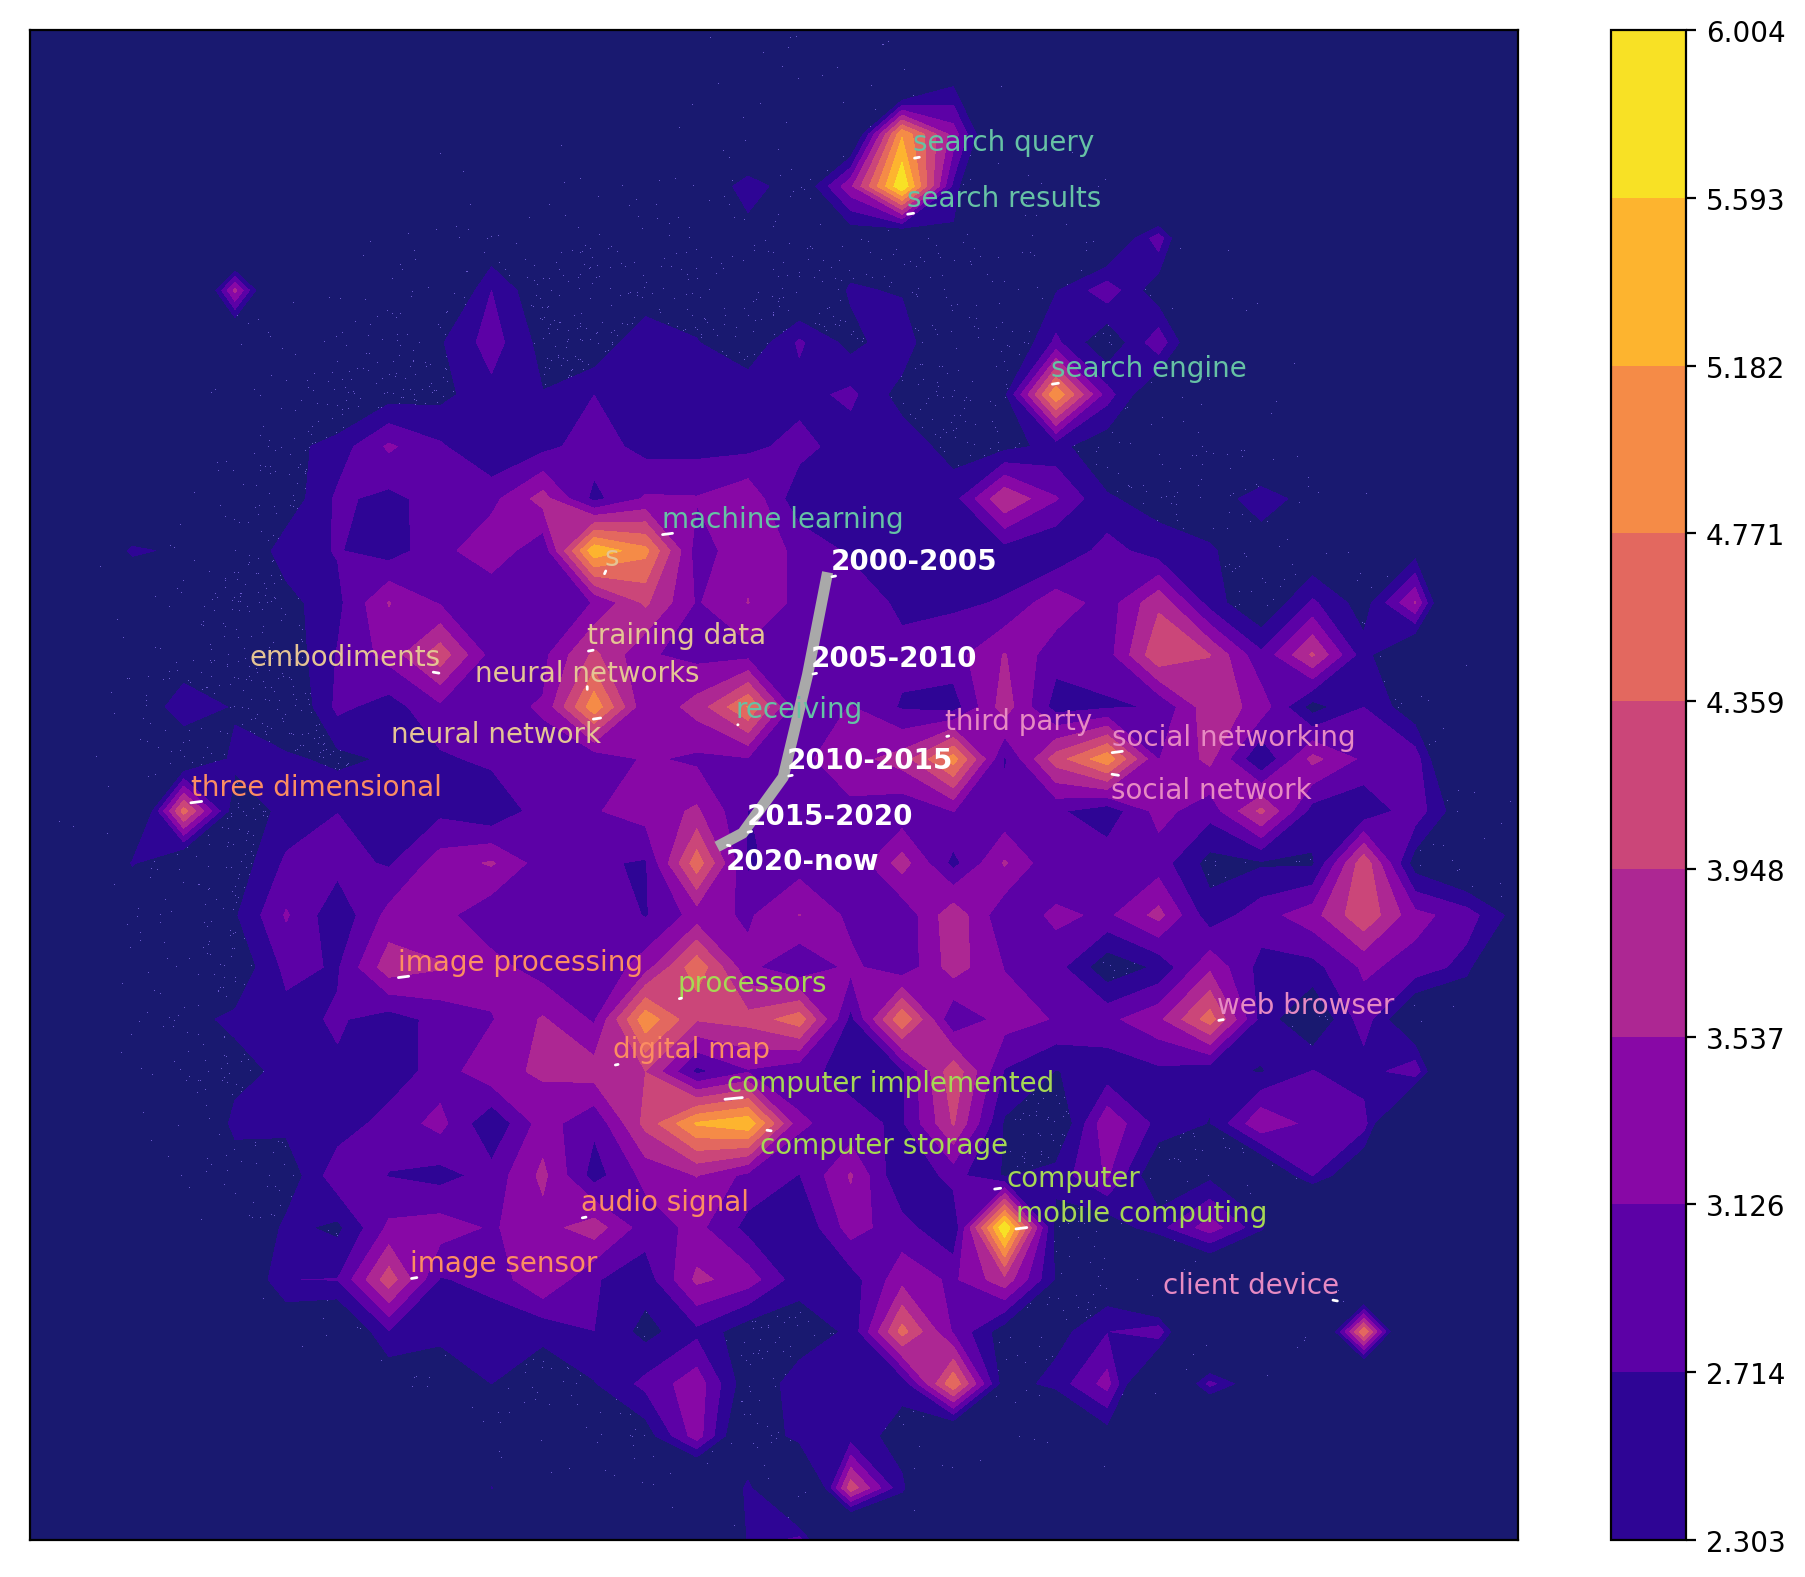

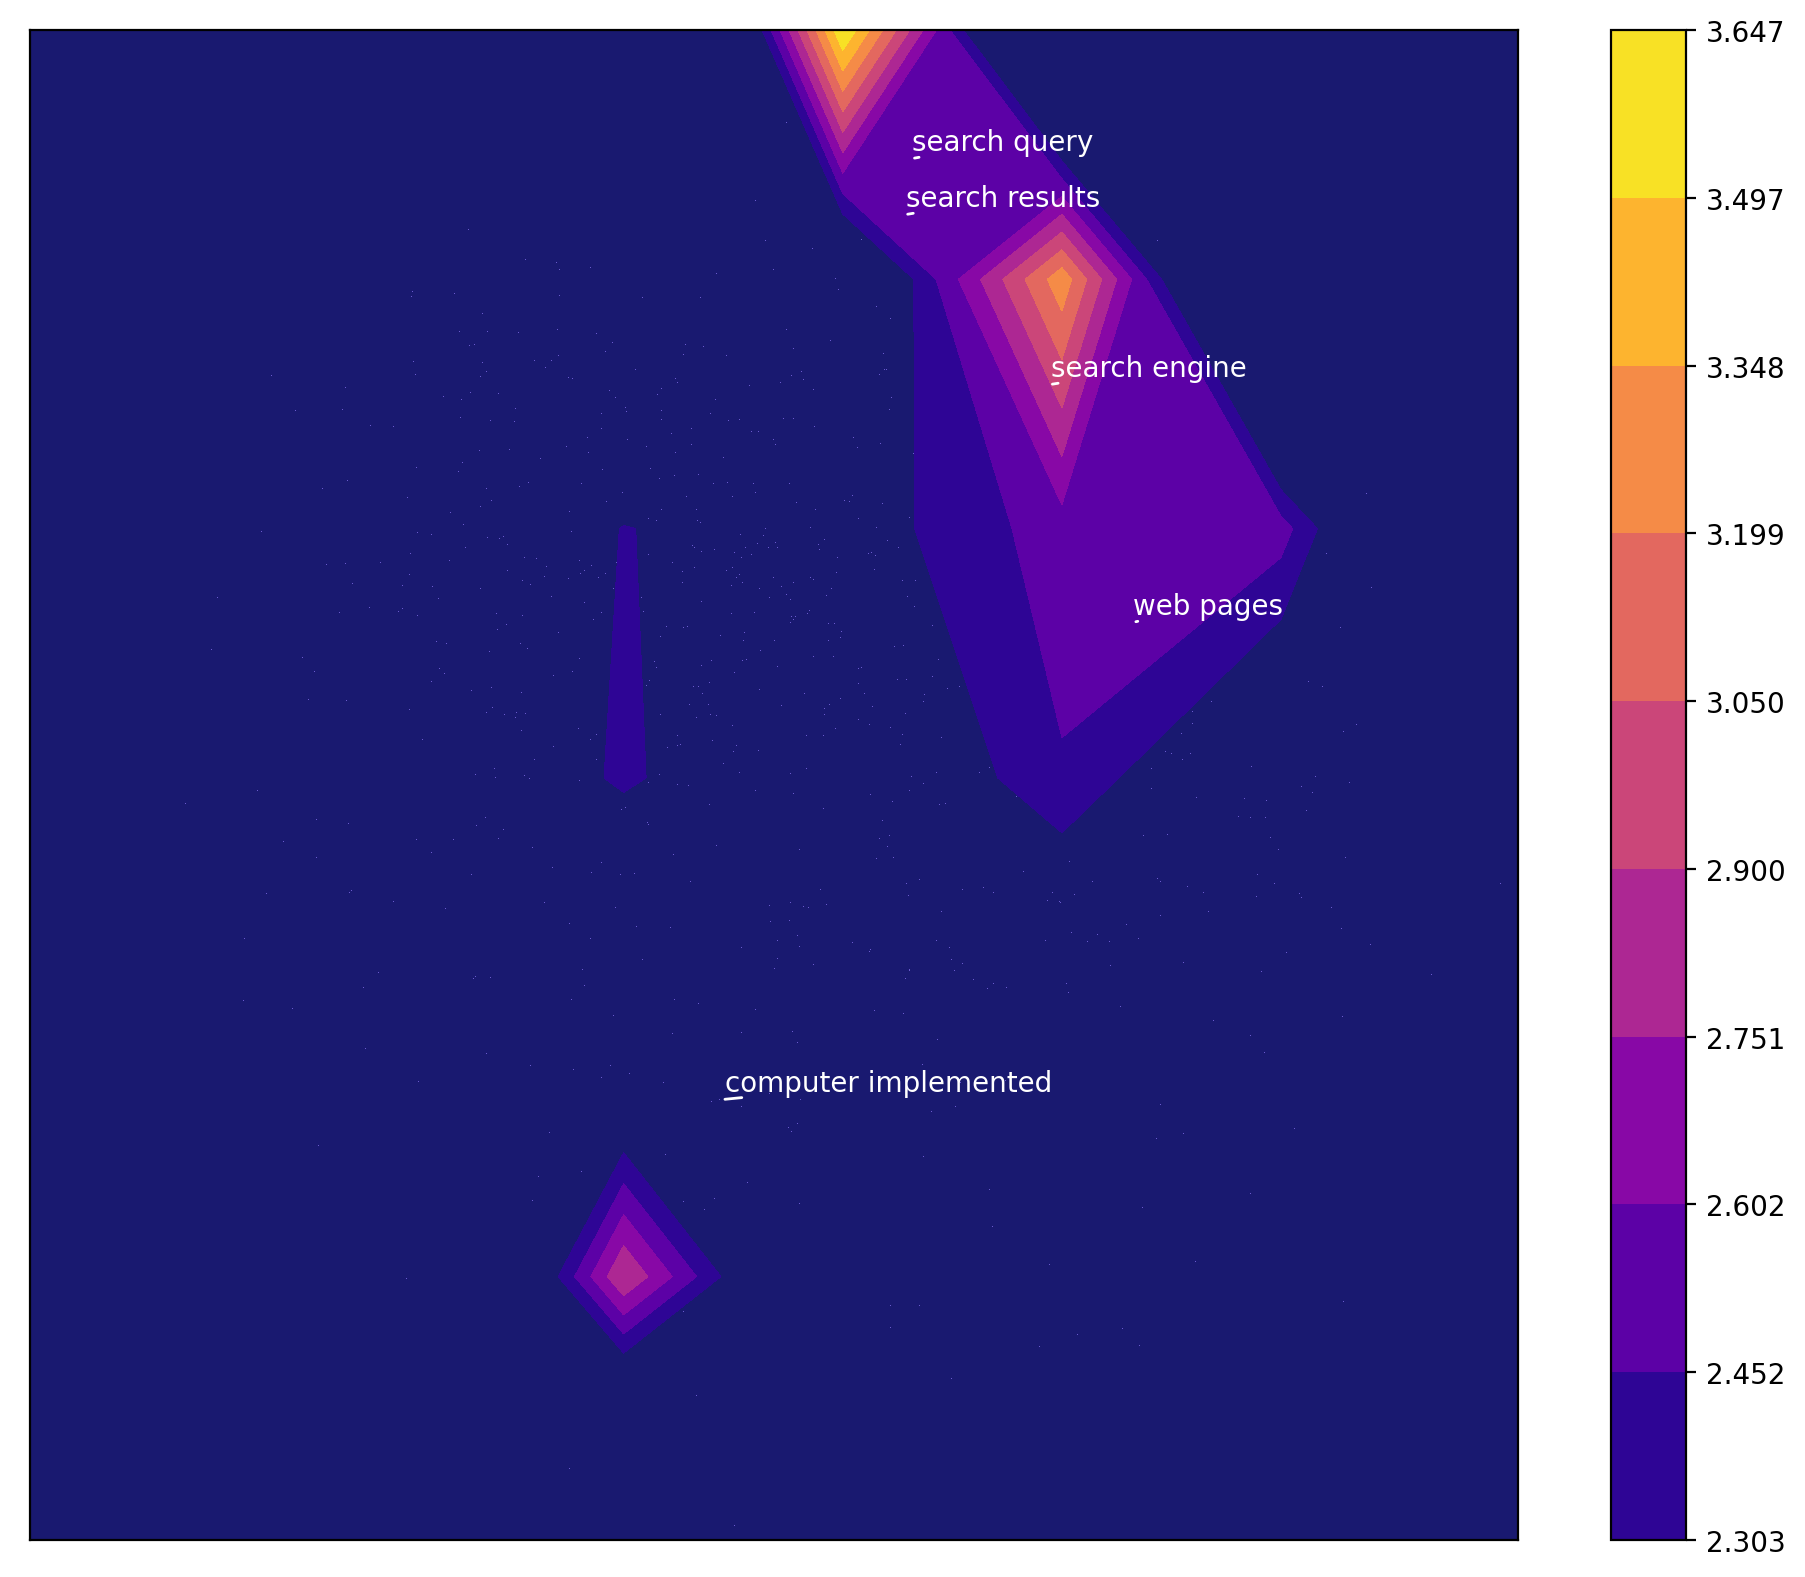

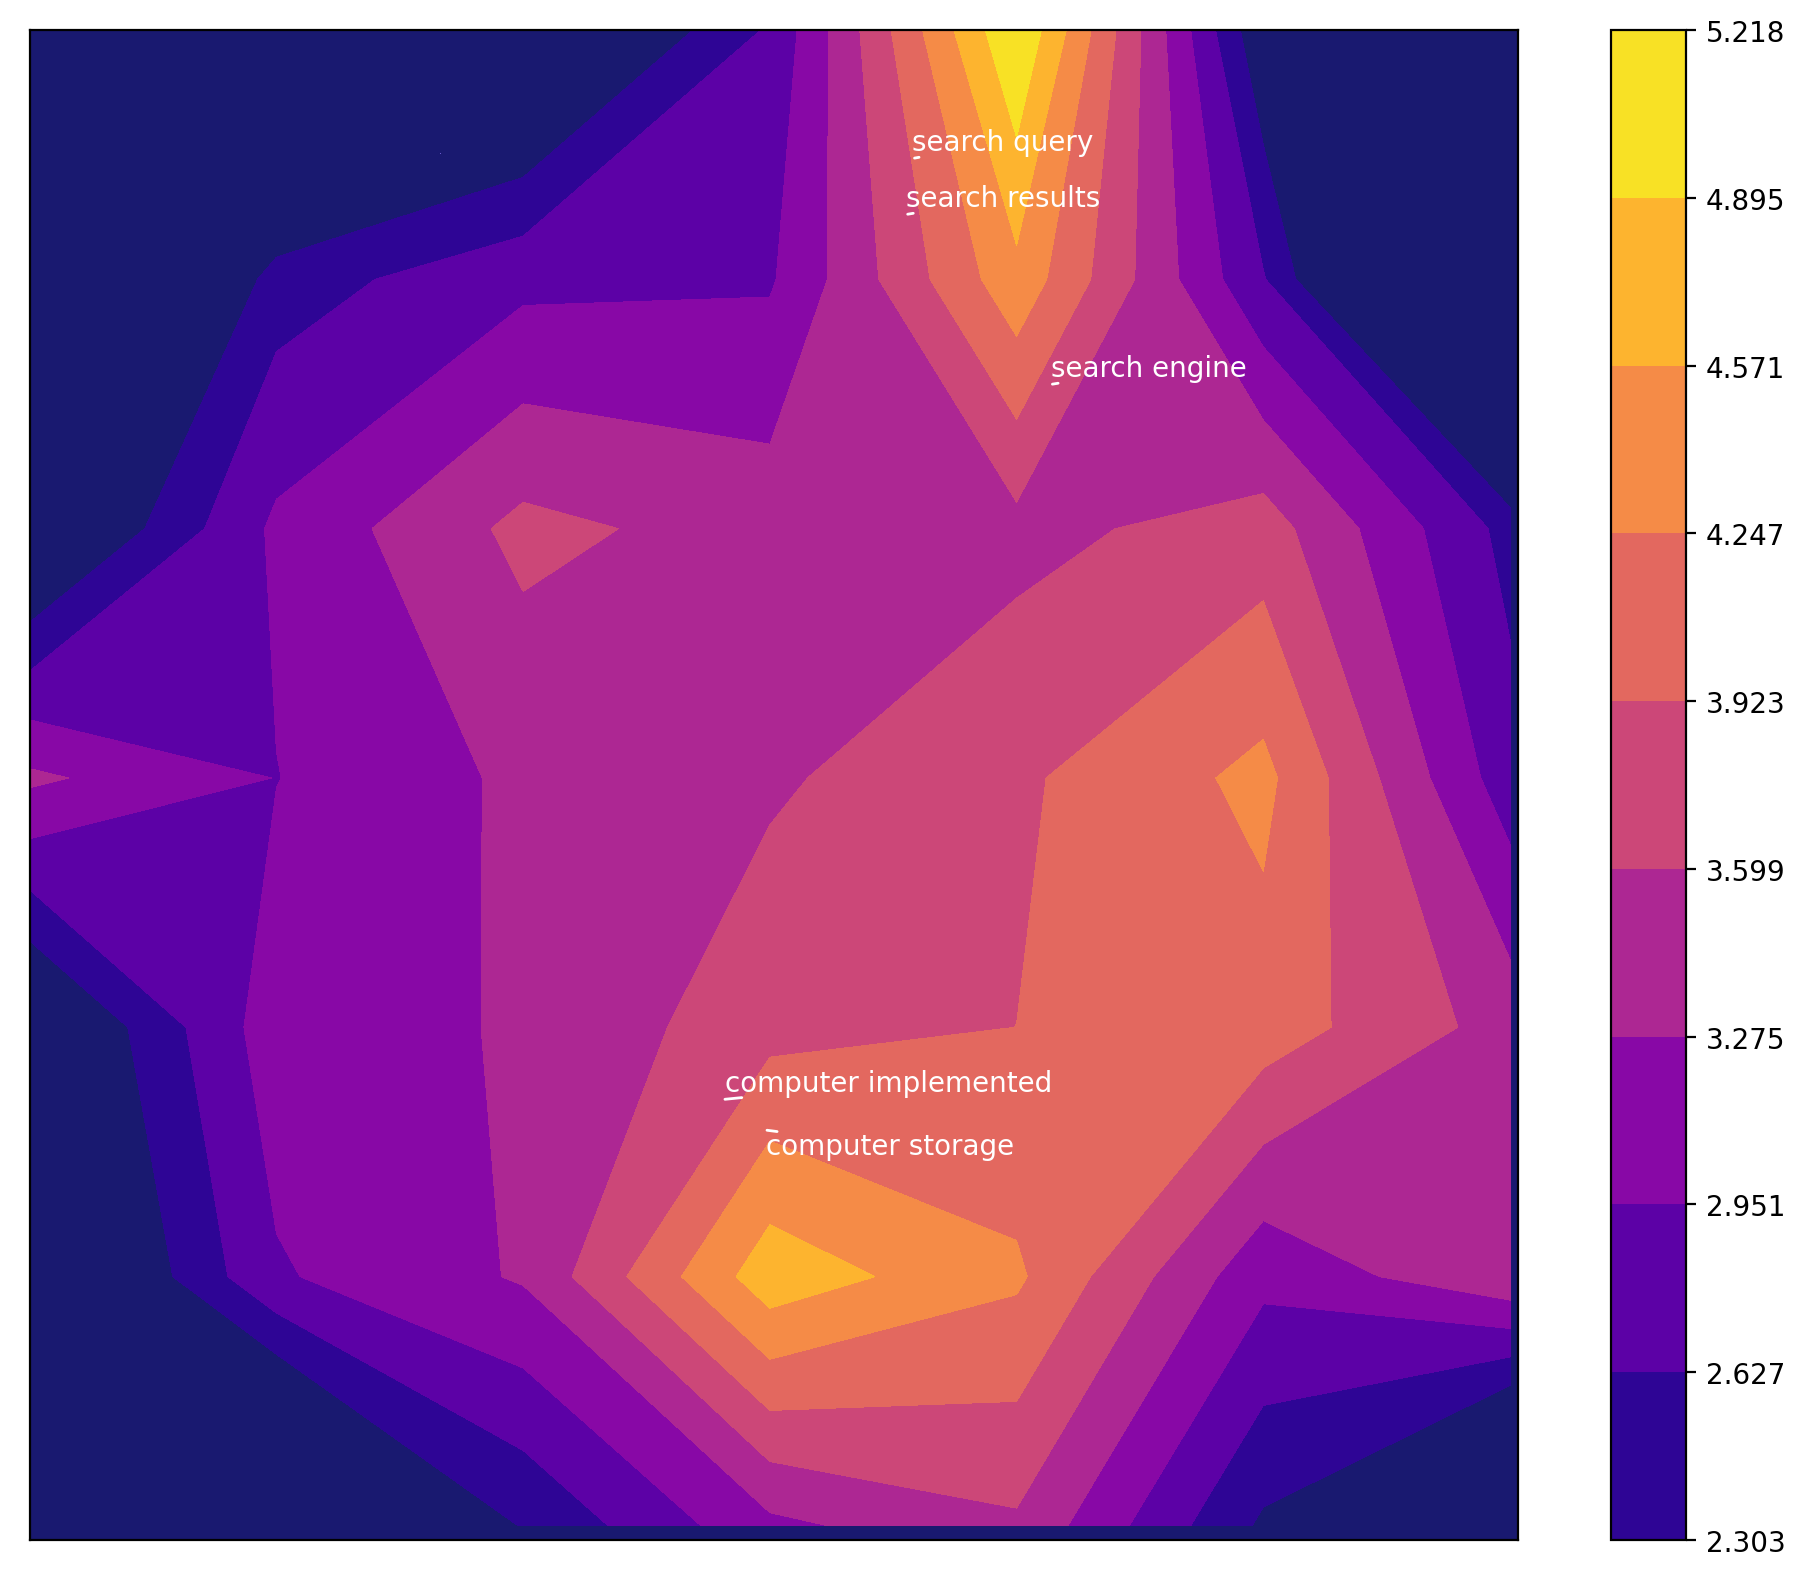

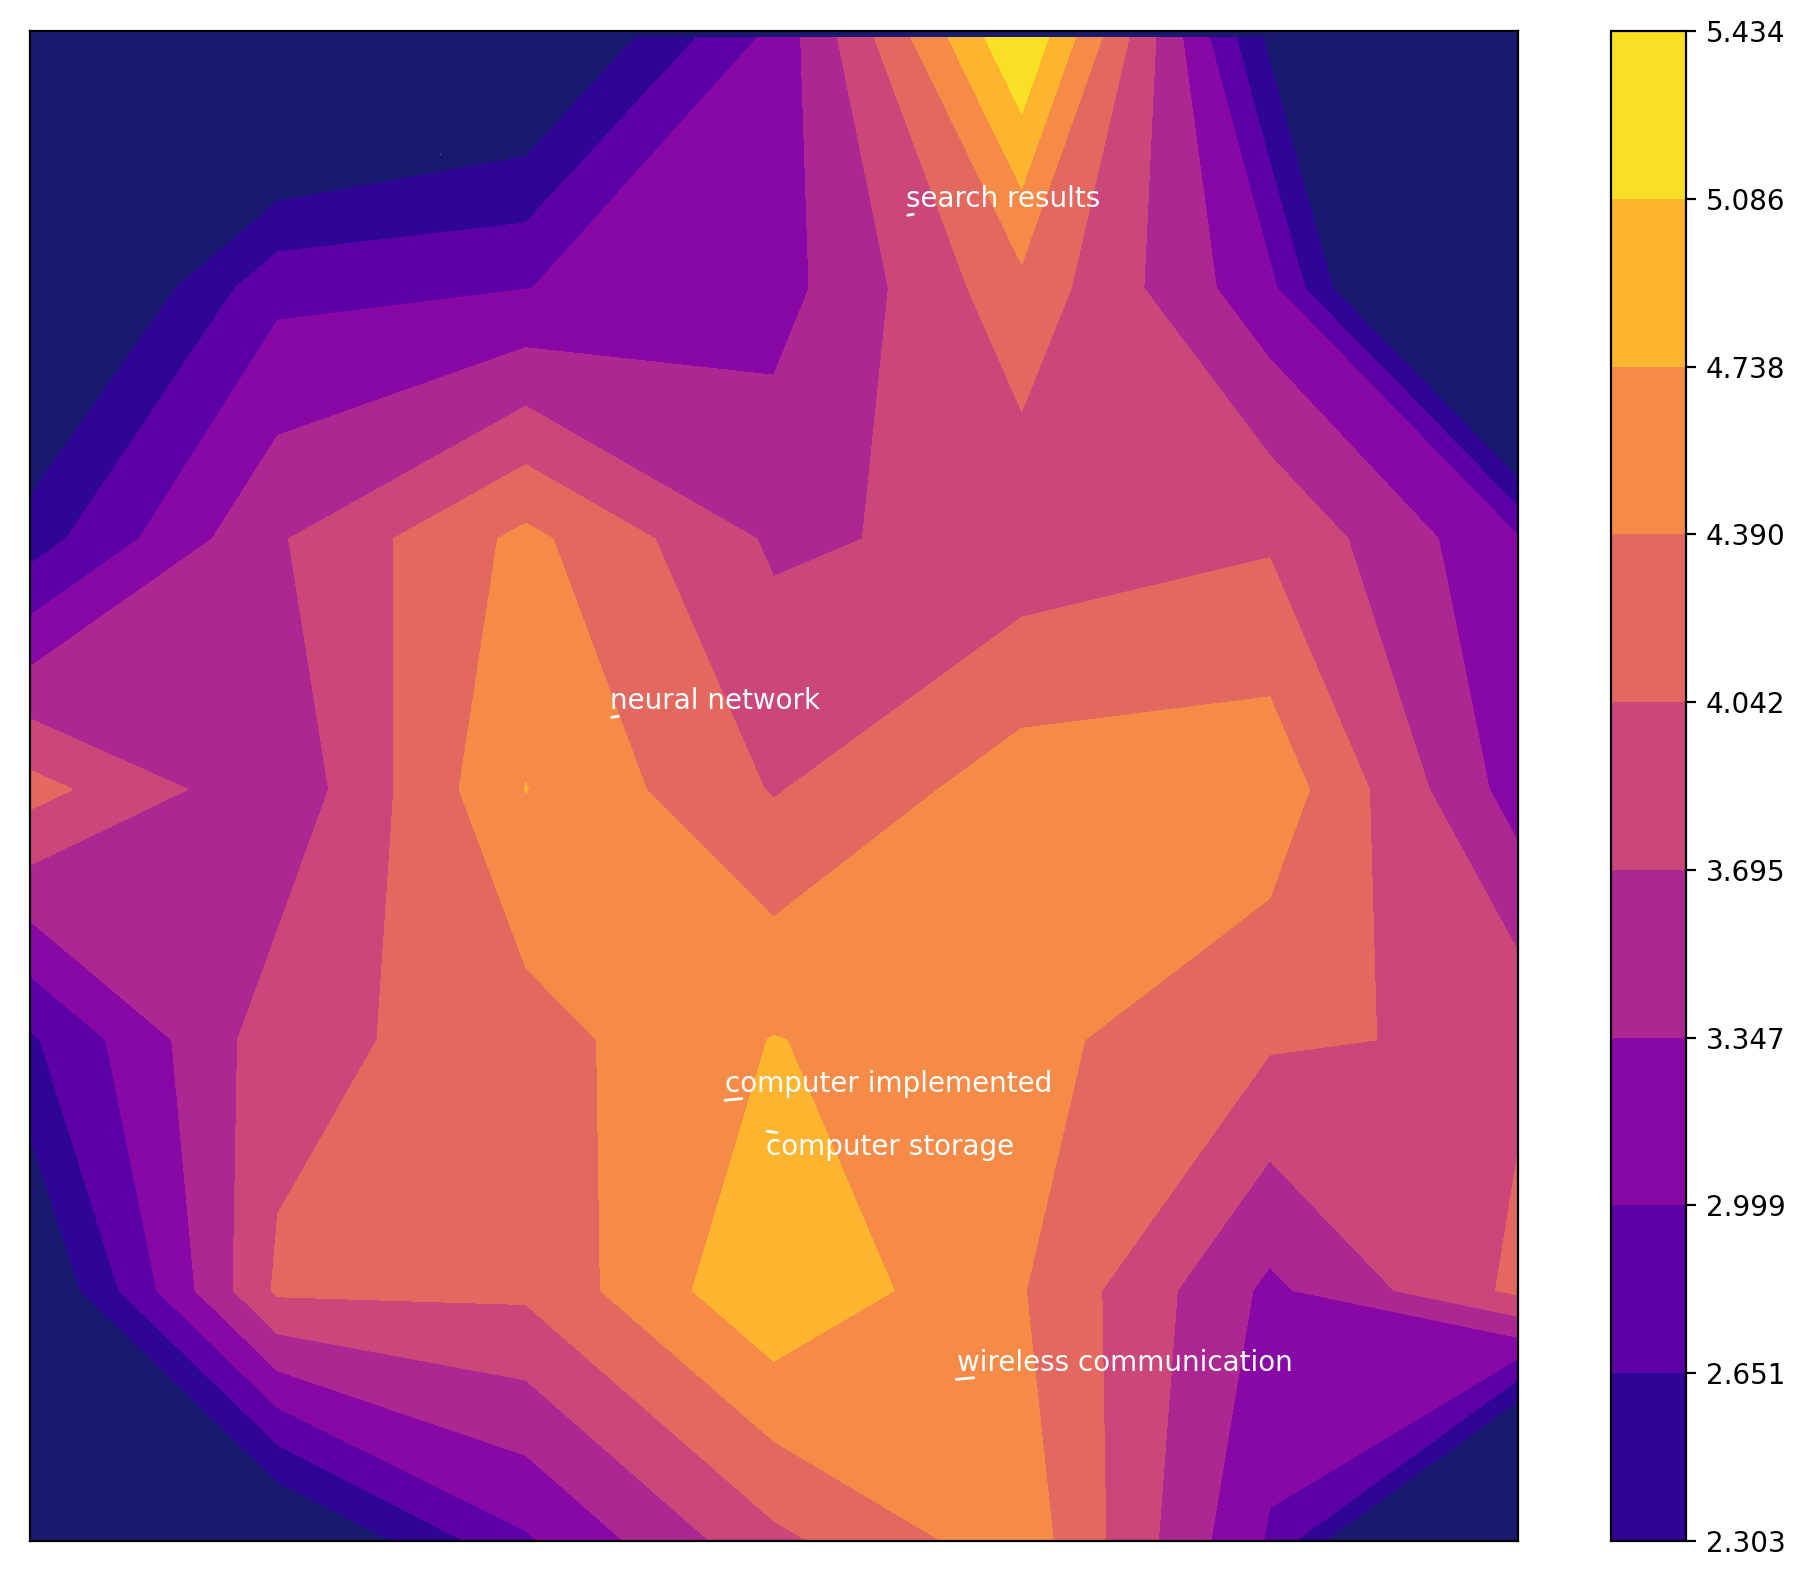

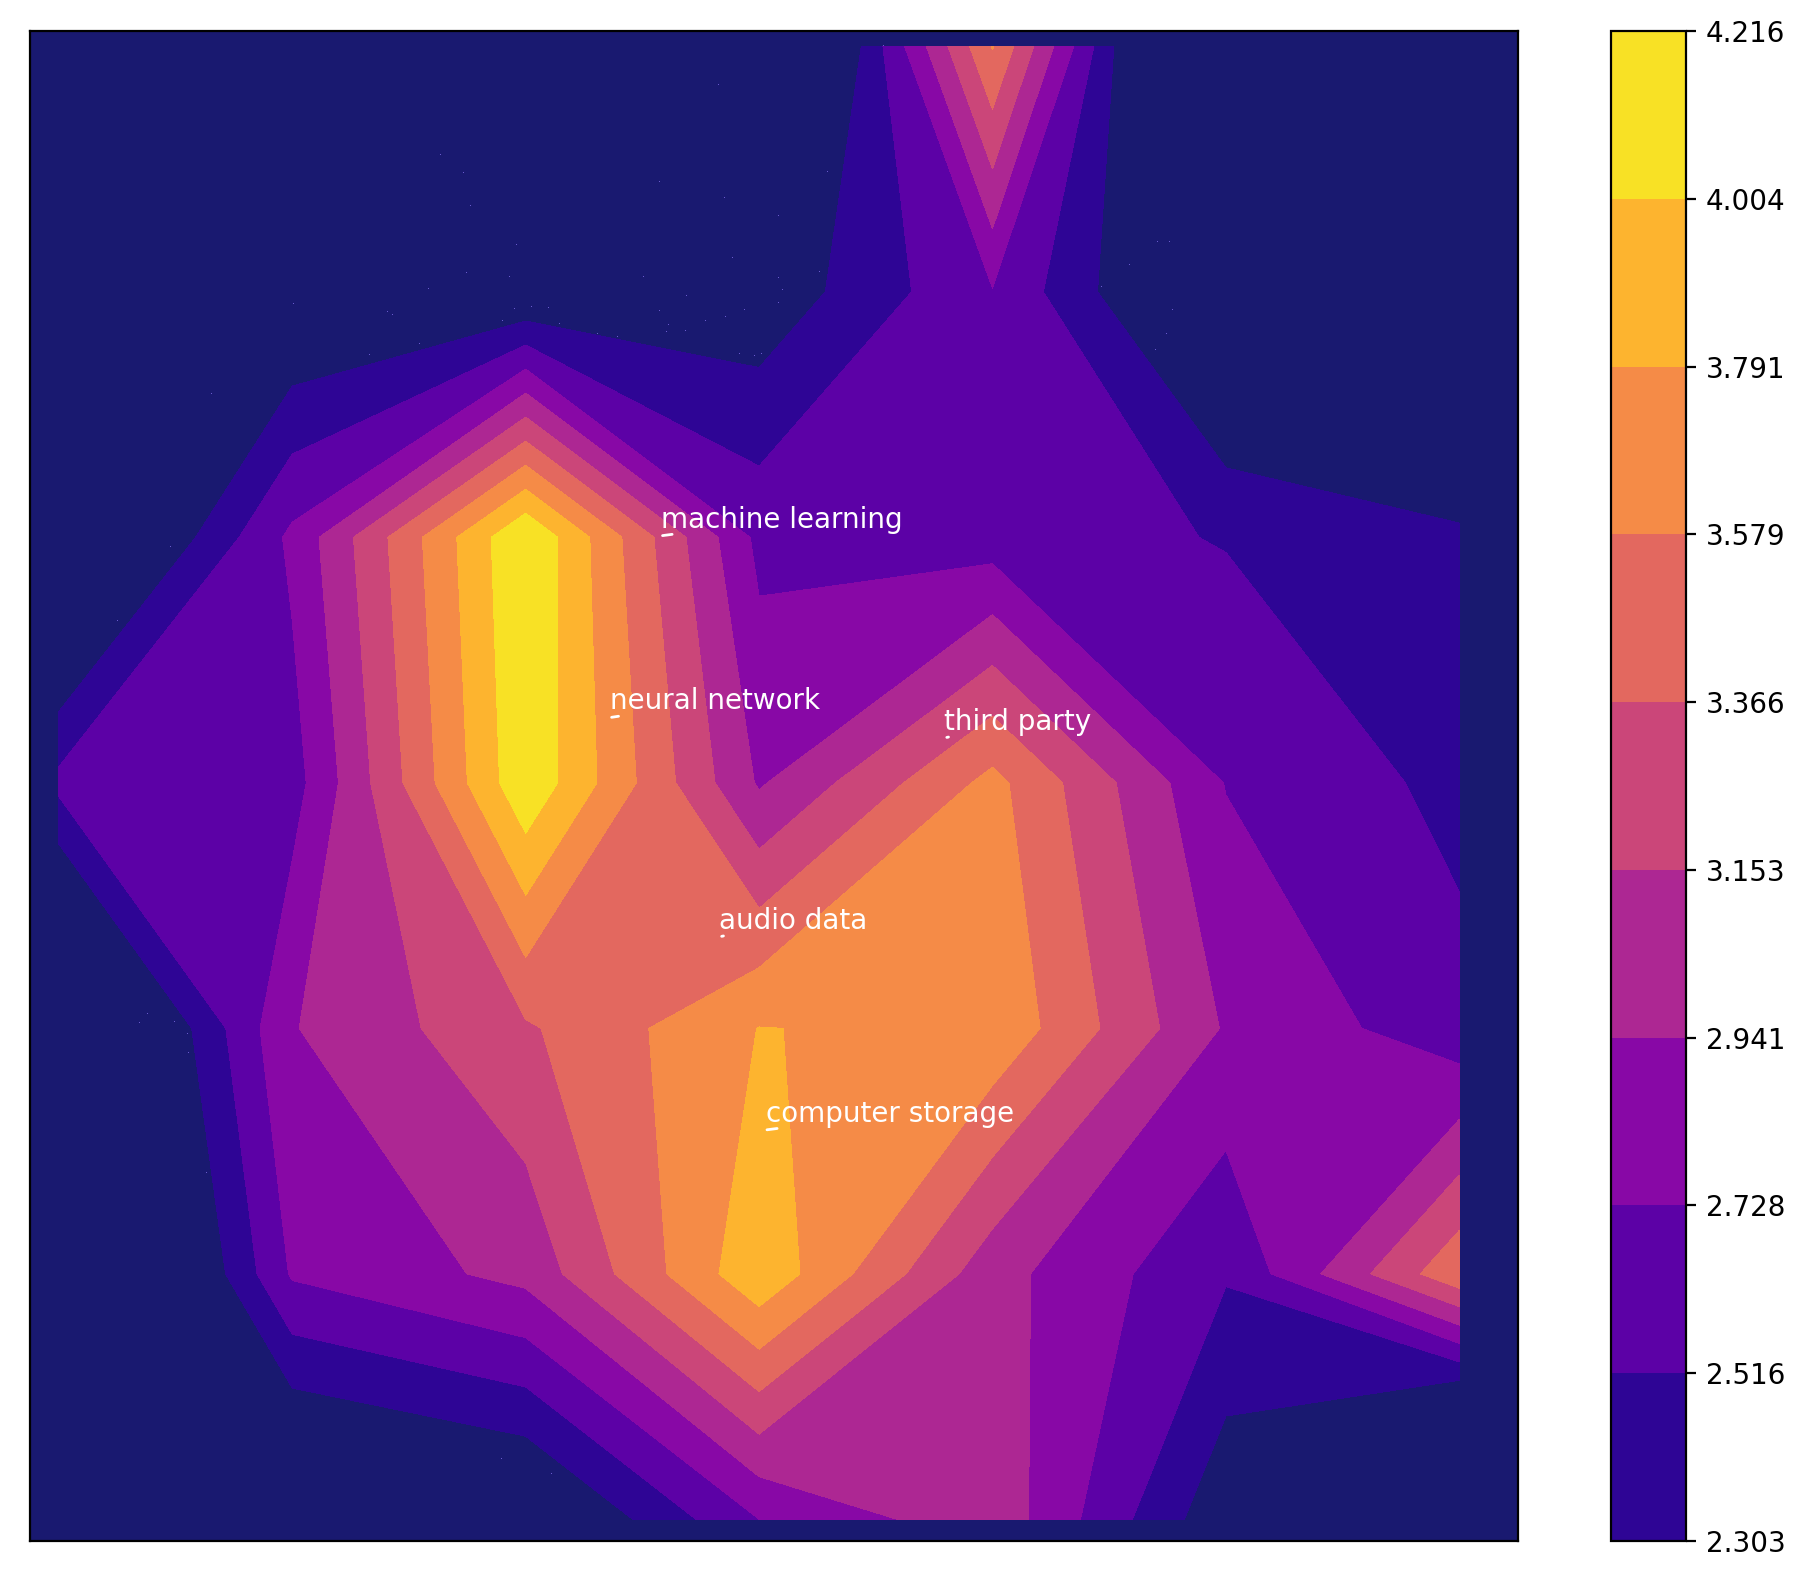

In [19]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from my_utils import get_keybert_model, model_name, word_vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from adjustText import adjust_text
from datetime import timedelta, datetime
from tqdm import tqdm
import math
from scipy import interpolate
import matplotlib.cm as cmx
import matplotlib.colors as colors
from astroML.plotting import scatter_contour

# In[2]:
p_data = "./data"
porj_name = "keywords_keyBert"
f_patent_keybert_p = "{}/patents/{}.pickle".format(p_data, porj_name)
f_patent_keybert_vec_p = "{}/patents/{}_vec.pickle".format(p_data, porj_name)
f_patent_keybert_clust_p = "{}/patents/{}_clust.pickle".format(p_data, porj_name)
f_patent_keybert_period_p = "{}/patents/{}_period.pickle".format(p_data, porj_name)

LOAD_DATA = True


# !!!
CLIP_THD = 0.5  # 3
PLOT_THD = 5
N_CLUST = 5
N_COMM_KW = 5
YEAR_BEG = 1990
YEAR_INT = 5
YEAR_END = 2022
HEAT_BINS = 30
SIM_DOTS_IMPS_INT = 0.5

# In[3]:
with open(f_patent_keybert_p, "rb") as f:
    df_patent_keybert = pickle.load(f)


def kwg_agg_func(l):
    l = [i[0] for i in l if isinstance(i, tuple)]
    return ", ".join(l)


def kwg_agg_func2(l):
    l = ["{:.5f}".format(i[1]) for i in l if isinstance(i, tuple)]
    return ", ".join(l)


f_patent_keybert_excel_p = "{}/patents/{}.xlsx".format(p_data, porj_name)
df_patent_keybert2 = df_patent_keybert.copy()
df_patent_keybert2["KWG"] = df_patent_keybert["KWG"].apply(kwg_agg_func)
df_patent_keybert2["importance"] = df_patent_keybert["KWG"].apply(kwg_agg_func2)
df_patent_keybert2.to_excel(f_patent_keybert_excel_p, index=False)
# In[5]:
def cleaning(df, col="KWG"):
    re_rm = r".*(research|also|method|way|invention|generation).*"
    re_rm_sub = r"^\d+ | \d+$|applying|implementation|implementated|applies|apply|including|includes|include|the |an |a |some |have |had |another |other |more |each |first |second |last"
    re_rm_sub2 = r"^ +| +$"
    re_rm_empty = r"^[^a-zA-Z]*$"

    df = df[df[col].apply(lambda x: re.match(re_rm, x) is None)]
    df[col] = df[col].apply(lambda x: re.sub(re_rm_sub, "", x))
    df[col] = df[col].apply(lambda x: re.sub(re_rm_sub2, "", x))
    df[col] = df[col].apply(lambda x: re.sub(r" +", " ", x))
    df = df[df[col].apply(lambda x: re.match(re_rm_empty, x) is None)]

    return df


def gen_df_kws(df, col="KWG"):
    keypairs = df["KWG"].sum()
    keypairs = pd.DataFrame(keypairs, columns=["KW", "importance"])
    keypairs_sum = keypairs.groupby("KW").sum().reset_index()
    keypairs_sum = cleaning(keypairs_sum, "KW")
    return keypairs_sum

    # In[]:


l_period = [datetime(YEAR_BEG, 1, 1)]
dt_end = datetime(YEAR_END, 1, 1)
l_df_period = []
while l_period[-1] < dt_end:
    l_period.append(datetime(l_period[-1].year + YEAR_INT, 1, 1))
    flags = (df_patent_keybert["publication_date"] >= l_period[-2]) & (
        df_patent_keybert["publication_date"] < l_period[-1]
    )
    df = df_patent_keybert[flags]
    if df.shape[0] > 0:
        l_df_period.append(
            {
                "dt_beg": l_period[-2],
                "dt_end": l_period[-1],
                "df": df,
                "df_kws": gen_df_kws(df, "KWG"),
                "n": df.shape[0],
            }
        )

if not LOAD_DATA:
    # In[5]:
    keypairs_sum = gen_df_kws(df_patent_keybert, "KWG")

    # In[6]: Distribution of keywords' importances
    imp = keypairs_sum["importance"]
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    ax[0].hist(imp, bins=30, log=True)
    ax[1].hist(imp[imp > CLIP_THD], bins=30, log=False)
    ax[0].set_ylabel("Freq")
    ax[1].set_ylabel("Freq")
    ax[0].set_xlabel("Importance")
    ax[1].set_xlabel(
        "Importance (>{:.0f})".format(CLIP_THD) if CLIP_THD > 0 else "Importance"
    )
    ax[0].set_title("Distribution of keywords' importances")
    fig.savefig("{}/plot/dist_of_imp.pdf".format(p_data), bbox_inches="tight")
    fig.show()

    # In[7]:
    df_kws = keypairs_sum[keypairs_sum["importance"] > CLIP_THD]

    # In[ ]:
    model_keybert = get_keybert_model(model_name["keyBert_mpnet"])

    # In[ ]: 获得每个关键词的词向量
    pbar = tqdm(total=df_kws.shape[0])

    def vec_fun(s):
        global model_keybert, tqdm
        wv = word_vec(s, model_keybert.model)
        pbar.update(1)
        return wv

    df_kws["vec"] = df_kws["KW"].apply(vec_fun)
    pbar.close()

    with open(f_patent_keybert_vec_p, "wb") as f:
        pickle.dump(df_kws, f)

else:
    with open(f_patent_keybert_vec_p, "rb") as f:
        df_kws = pickle.load(f)

# In[]:
pca = PCA(n_components=2)  # 降到2维
X = np.stack(df_kws["vec"])[:, 0, :]  # 导入数据，维度为768
pca.fit(X)
X2 = pca.fit_transform(X)  # 降维后的数据放在newX里
df_kws["X1"] = X2[:, 0]
df_kws["X2"] = X2[:, 1]

# In[]:
def get_cmap(N):
    """Returns a function that maps each index in 0, 1,.. . N-1 to a distinct
    RGB color."""
    color_norm = colors.Normalize(vmin=0, vmax=N - 1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap="Set2")
    # scalar_map = cmx.ScalarMappable(norm=color_norm, cmap="hsv")

    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)

    return map_index_to_rgb_color


idx2color = get_cmap(N_CLUST + 1)

# In[ ]:
# if not LOAD_DATA:
kmeans = KMeans(n_clusters=N_CLUST, random_state=0).fit(X2)
centers = kmeans.cluster_centers_
print("Centers: {}".format(centers))

# In[ ]:
l_clust = []
df_kws["clust"] = -1
for i in range(N_CLUST):
    df_kws_clust = df_kws.iloc[kmeans.labels_ == i].sort_values(
        "importance", ascending=False
    )
    df_comm_kw = df_kws_clust.iloc[:N_COMM_KW, :]
    l_comm_idx = df_kws_clust.index
    df_kws.loc[l_comm_idx, "clust"] = i
    s_comm_kw = ", ".join(df_comm_kw["KW"])
    l_clust.append(
        {
            "i": i,
            "center": kmeans.cluster_centers_[i],
            "n": df_kws_clust.shape[0],
            "df_kws_clust": df_kws_clust,
            "df_comm_kw": df_comm_kw,
            "l_comm_idx": l_comm_idx,
            "s_comm_kw": s_comm_kw,
        }
    )

# In[]:
merge_col = [i for i in df_kws.columns if i != "importance"]
for i in range(len(l_df_period)):
    df_p_kws = l_df_period[i]["df_kws"]
    l_df_period[i]["df_kws"] = df_p_kws.merge(df_kws[merge_col], how="left", on="KW")

# In[]:
for i in range(len(l_df_period)):
    df_p_kws = l_df_period[i]["df_kws"]
    l_df_period[i]["df_kws"] = df_p_kws[~df_p_kws["KW"].duplicated()]
    df_p_kws = l_df_period[i]["df_kws"]
    sum_imp = df_p_kws["importance"].sum()
    weight_x1 = (df_p_kws["X1"] * df_p_kws["importance"]).sum() / sum_imp
    weight_x2 = (df_p_kws["X2"] * df_p_kws["importance"]).sum() / sum_imp
    l_df_period[i]["pos_weight"] = (weight_x1, weight_x2)


from my_utils import plot_kws, get_sim_dots


# In[ ]:

# scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_plot_kws = df_kws[df_kws["importance"] > PLOT_THD]
plot_kws(
    fig,
    ax,
    color_func=idx2color,
    df_plot_kws=df_plot_kws,
    bins=HEAT_BINS,
    a_sim_dots=None,
    n_comm_kws=N_COMM_KW,
    l_clust=l_clust,
    l_df_period=None,
    year_int=YEAR_INT,
    period_arrow=False,
    period_line=False,
    kw_color_func_flag=False,
    p_data=p_data,
    file_name="scatter",
)

# heat
a_sim_dots = get_sim_dots(df_kws=df_kws, sim_dots_imp_int=SIM_DOTS_IMPS_INT)
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 10))
plot_kws(
    fig2,
    ax2,
    color_func=idx2color,
    df_plot_kws=None,
    bins=HEAT_BINS,
    a_sim_dots=a_sim_dots,
    n_comm_kws=N_COMM_KW,
    l_clust=l_clust,
    l_df_period=l_df_period,
    year_int=YEAR_INT,
    period_arrow=False,
    period_line=True,
    kw_color_func_flag=True,
    p_data=p_data,
    file_name="heat",
)

# In[]:
# yearly heat
df_xy_nonan = df_kws[["X1", "X2"]].dropna()
x_range = [df_xy_nonan["X1"].min(), df_xy_nonan["X1"].max()]
y_range = [df_xy_nonan["X2"].min(), df_xy_nonan["X2"].max()]
for i in range(len(l_df_period)):
    if i in [0]:
        continue
    df_kws_p = l_df_period[i]["df_kws"]
    a_sim_dots_p = get_sim_dots(df_kws=df_kws_p, sim_dots_imp_int=SIM_DOTS_IMPS_INT)

    n_dt_beg = l_df_period[i]["dt_beg"].year
    if i < len(l_df_period) - 1:
        s_year = "{}-{}".format(n_dt_beg, n_dt_beg + YEAR_INT)
    else:
        s_year = "{}-now".format(n_dt_beg)

    fig3, ax3 = plt.subplots(1, 1, figsize=(12, 10))
    ax3.set_xlim(x_range[0], x_range[1])
    ax3.set_ylim(y_range[0], y_range[1])
    plot_kws(
        fig3,
        ax3,
        color_func=None,
        df_plot_kws=None,
        bins=7,
        a_sim_dots=a_sim_dots_p,
        n_comm_kws=N_COMM_KW,
        l_clust=[{"df_kws_clust": df_kws_p.sort_values("importance", ascending=False)}],
        l_df_period=None,
        year_int=YEAR_INT,
        period_arrow=False,
        period_line=False,
        kw_color_func_flag=False,
        p_data=p_data,
        file_name="heat_" + s_year,
    )


# In[]:
f_patent_simp_clust_p = "{}/patents/sim_{}_clust.xlsx".format(p_data, porj_name)
f_patent_simp_period_p = "{}/patents/sim_{}_period.xlsx".format(p_data, porj_name)

df_kws[["KW", "importance", "X1", "X2", "clust"]].to_excel(
    f_patent_simp_clust_p, index=False
)

for i in range(len(l_df_period)):
    l_df_period[i]["df_kws"]["dt_beg"] = l_df_period[i]["dt_beg"].year

df_period_all = pd.concat([i["df_kws"] for i in l_df_period])
df_period_all[["KW", "importance", "X1", "X2", "clust", "dt_beg"]].to_excel(
    f_patent_simp_period_p, index=False
)
